<a href="https://colab.research.google.com/github/AshkanSamavatian/Thesis/blob/main/Thesis_10th_(ROBERTA_and_BERT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Installing and Importing Required Libraries**



In [ ]:
#Installing required libraries for the project
!pip install -q transformers datasets evaluate torch
!pip install -U transformers
!pip install -q datasets
!pip install -q bert-score
!pip install -q git+https://github.com/google-research/bleurt.git
!pip install -q nlpaug
!pip install -q tabulate
!pip install -q torch transformers datasets accelerate

#Importing fundamental libraries for the project
import os
import shutil
import random
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import json
from google.colab import files, drive
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_dataset
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, DataCollatorWithPadding, DataCollatorForLanguageModeling, Trainer, EarlyStoppingCallback, AutoModelForMaskedLM, pipeline, T5ForConditionalGeneration, T5Tokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer
from evaluate import load
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from scipy.stats import ttest_ind, wilcoxon
from torch.nn import CrossEntropyLoss
import nlpaug.augmenter.word as naw
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tabulate import tabulate
os.environ["WANDB_DISABLED"]="true"
torch.autograd.set_detect_anomaly(True)
%env CUDA_LAUNCH_BLOCKING=1
transformers.utils.logging.set_verbosity_error()

#Defining a reproducibility function
def set_seed(seed=101):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True  #Ensuring deterministic behavior
    torch.backends.cudnn.benchmark=False  #Disabling automatic optimizations

#Setting seed globally
set_seed(101)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### **Importing, Reviewing, and Preparing FLUTE Dataset for the Project**

In [ ]:
#Importing the FLUTE dataset
uploaded=files.upload()

#Reading and storing the FLUTE dataset
flute_df=pd.read_csv("train.csv")

#Overviewing the FLUTE dataset
flute_df.info()

Saving train.csv to train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7534 entries, 0 to 7533
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7534 non-null   int64 
 1   premise      7534 non-null   object
 2   hypothesis   7534 non-null   object
 3   label        7534 non-null   object
 4   explanation  7530 non-null   object
 5   split        7534 non-null   object
 6   type         7534 non-null   object
 7   idiom        1768 non-null   object
dtypes: int64(1), object(7)
memory usage: 471.0+ KB


In [ ]:
#Monitoring the FLUTE dataset
flute_df.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
0,1,I left my adult son home for a few days and ju...,I was gone for only a few days and my consider...,Contradiction,Most people would not consider leaving dirty d...,train,Sarcasm,NaN
1,2,I just caught a guy picking up used chewing gu...,it was such a pleasant sight to see a guy pick...,Contradiction,Picking up used chewing gum is really unhygien...,train,Sarcasm,NaN
2,3,You could feel their sudden appearance in the ...,Their sudden appearance in the farmhouse was l...,Entailment,A gust of arctic wind is an icy blast that is ...,train,Simile,NaN
3,4,"April's had never left, perfectly white and fu...","April's had never left, like a toothpaste comm...",Entailment,A toothpaste commercial is something that is a...,train,Simile,NaN
4,5,I cooked a meal for family and it came out hor...,I feel terrible that the meal I cooked for my ...,Entailment,It is often very embarrassing when someone coo...,train,CreativeParaphrase,NaN


In [ ]:
#Defining a function to analyze and review the columns in the FLUTE dataset
def analyze_columns(dataframe, columns):
    """
    Analyze specified columns of a DataFrame by providing the number of unique values
    and the value counts for each column.
    Args:
        dataframe (pd.DataFrame): The DataFrame to analyze.
        columns (list): List of column names to analyze.
    Returns:
        dict: A dictionary where each key is a column name, and the value is a tuple
              (number_of_unique_values, value_counts_series).
    """
    analysis_results={}
    for column in columns:
        if column in dataframe.columns:
            unique_count=len(set(dataframe[column]))
            value_counts=dataframe[column].value_counts()
            analysis_results[column]=(unique_count, value_counts)
        else:
            print(f"Warning: Column '{column}' not found in the DataFrame.")
    return analysis_results

#Reviewing the "type", "label", "premise", "hypothesis", and "explanation" columns in the FLUTE dataset
results=analyze_columns(flute_df, ["type", "label", "premise", "hypothesis", "explanation"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: type
Number of unique values: 5
Value counts:
type
Sarcasm               2216
Idiom                 1768
Simile                1250
Metaphor              1250
CreativeParaphrase    1050
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    4350
Entailment       3184
Name: count, dtype: int64
--------------------------------------------------
Column: premise
Number of unique values: 5492
Value counts:
premise
I am worried I will not be able to go to my fathers birthday party.                                            6
I've been hearing some strange noises around the house at night.                                               6
I was really stressed out and grad school and had no choice but to drop out to keep my sanity.                 6
I missed my flight that I paid heavily for, I was so annoyed                                                   6
I found drugs in my son's r

In [ ]:
#Defining the validation size
validation_size=0.2

#Spliting the FLUTE dataset into training and validation sets
flute_train, flute_val=train_test_split(flute_df, test_size=validation_size, random_state=101)

#Checking the sizes of the splits
print(f"FLUTE Training set size: {len(flute_train)}")
print(f"FLUTE Validation set size: {len(flute_val)}")

FLUTE Training set size: 6027
FLUTE Validation set size: 1507


In [ ]:
#Overviewing the FLUTE Training set
flute_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6027 entries, 2279 to 4959
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           6027 non-null   int64 
 1   premise      6027 non-null   object
 2   hypothesis   6027 non-null   object
 3   label        6027 non-null   object
 4   explanation  6023 non-null   object
 5   split        6027 non-null   object
 6   type         6027 non-null   object
 7   idiom        1416 non-null   object
dtypes: int64(1), object(7)
memory usage: 423.8+ KB


In [ ]:
#Monitoring the FLUTE Training set
flute_train.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
2279,2280,Some unintelligent and unsuccessful young pers...,Some bright young thing had gotten ahold of a ...,Contradiction,A bright young thing is a young person who is ...,train,Idiom,bright young thing
1308,1309,"Once now remember, this is a vacation, not car...","Once now remember, this is a vacation, not car...",Contradiction,To run amok means to go awry or to act out of ...,train,Idiom,run amok
6921,6922,Now he feels agitated,Now he feels like a high mountain lake without...,Contradiction,A mountain lake without any wind stirring it i...,train,Simile,NaN
4155,4156,I had a box chocolate when my doctor advised a...,I broke my diet by eating a box of chocolates ...,Contradiction,A diet is often broken when someone eats somet...,train,Sarcasm,NaN
6323,6324,"It wasn't glib or run of the mill ,it wasn't i...","It wasn't glib or run of the mill ,it didn't g...",Entailment,The idiom in one ear and out the other is used...,train,Idiom,in one ear and out the other


In [ ]:
#Reviewing the "type" and "label" columns in the FLUTE training set
results=analyze_columns(flute_train, ["type", "label"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: type
Number of unique values: 5
Value counts:
type
Sarcasm               1759
Idiom                 1416
Metaphor              1014
Simile                1005
CreativeParaphrase     833
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    3478
Entailment       2549
Name: count, dtype: int64
--------------------------------------------------


In [ ]:
#Overviewing the FLUTE Validation set
flute_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1507 entries, 4822 to 3176
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1507 non-null   int64 
 1   premise      1507 non-null   object
 2   hypothesis   1507 non-null   object
 3   label        1507 non-null   object
 4   explanation  1507 non-null   object
 5   split        1507 non-null   object
 6   type         1507 non-null   object
 7   idiom        352 non-null    object
dtypes: int64(1), object(7)
memory usage: 106.0+ KB


In [ ]:
#Monitoring the FLUTE Validation set
flute_val.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
4822,4823,My boss suddenly just took that project I was ...,I'm so glad my boss just took that project I h...,Contradiction,The boss taking a project away from an employ...,train,Sarcasm,NaN
6862,6863,Clementine was pinned securely,Clementine was pinned like a butterfly in a gl...,Entailment,A butterfly in a glass case is pinned down and...,train,Simile,NaN
1571,1572,"Once we commit to a significant response, it n...","Once we commit to a significant response, it n...",Entailment,"To bear fruit means to yield results, so in th...",train,Idiom,bear fruit
3293,3294,"He was about sixty, short and fat .","He was about sixty, like a big soccer ball .",Entailment,"A soccer ball is short and fat, so the simile ...",train,Simile,NaN
4713,4714,"The overhead light buzzed soothingly, at the e...",The overhead light buzzed at the edge of heari...,Contradiction,"Flies buzz irritatingly, not soothingly",train,Simile,NaN


In [ ]:
#Reviewing the "type" and "label" columns in the FLUTE validation set
results=analyze_columns(flute_val, ["type", "label"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: type
Number of unique values: 5
Value counts:
type
Sarcasm               457
Idiom                 352
Simile                245
Metaphor              236
CreativeParaphrase    217
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    872
Entailment       635
Name: count, dtype: int64
--------------------------------------------------


In [ ]:
#Importing the FLUTE test set
uploaded=files.upload()

#Reading and storing the FLUTE test set
test_df=pd.read_csv("test2.csv")

#Overviewing the FLUTE test set
test_df.info()

Saving test2.csv to test2.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1498 non-null   int64 
 1   premise      1498 non-null   object
 2   hypothesis   1498 non-null   object
 3   label        1498 non-null   object
 4   explanation  1498 non-null   object
 5   split        1498 non-null   object
 6   type         1498 non-null   object
 7   idiom        250 non-null    object
dtypes: int64(1), object(7)
memory usage: 93.8+ KB


In [ ]:
#Monitoring the FLUTE test set
test_df.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
0,1,I went to a buffet the other day and they kick...,I felt amazing when the buffet staff threw me ...,Contradiction,Being thrown out of a buffet for eating too mu...,test,Sarcasm,NaN
1,2,"Because I know Ronin's confidantes, and they w...","Because I know Ronin's confidantes, and they w...",Entailment,To tell tales out of school means to share sec...,test,Idiom,tell tales out of school
2,3,"I just broke up with my girlfriend, we were to...",Loving this life of loneliness after breaking ...,Contradiction,Loneliness is not a desirable feeling and is o...,test,Sarcasm,NaN
3,4,The government allowed the value of the ruble ...,The government floated the ruble for a few mon...,Entailment,Floating the ruble means that the government a...,test,Metaphor,NaN
4,5,Another girl was flirting with my boyfriend at...,I really felt cooperative when I saw another g...,Contradiction,Seeing someone else flirt with your boyfriend ...,test,Sarcasm,NaN


In [ ]:
#Reviewing the "type", "label", "premise", "hypothesis", and "explanation" columns in the FLUTE test set
results=analyze_columns(test_df, ["type", "label", "premise", "hypothesis", "explanation"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: type
Number of unique values: 4
Value counts:
type
Sarcasm     750
Idiom       250
Simile      250
Metaphor    248
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    835
Entailment       663
Name: count, dtype: int64
--------------------------------------------------
Column: premise
Number of unique values: 1186
Value counts:
premise
The kitchen was a total mess with old pile up of dishes and dried up food on the stove.                    3
When my boyfriend left me for another woman on Valentine's Day that really sucked being left all alone.    3
My landlord takes rent but he doesn't want to make any reparations.                                        3
My dishwasher leaked and we had to have our whole kitchen and living room redone due to the damages.       3
I can't get pregnant but all my friends are having kids.                                                   3
       

### **Evaluating Figurative Language Understanding by Designing the Probing Task (Holmes’ Approaach)**


Evaluating model: roberta-base


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]


Evaluating Sarcasm for roberta-base


<ipython-input-15-e227ecae488d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["hypothesis"]=filtered_data["hypothesis"].fillna("N/A").astype(str)
<ipython-input-15-e227ecae488d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["explanation"]=filtered_data["explanation"].fillna("N/A").astype(str)


Results for Sarcasm (First 5 Examples):
Pair 1:
  Figurative: I broke my diet by eating a box of chocolates and I feel very proud about it
  Literal: A diet is often broken when someone eats something they are not supposed to and in this case, it is a box of chocolates which implies that the person feels guilty or ashamed rather than proud.
  Figurative Score: -0.0185
  Literal Score: -0.0641
  Model Preference: Figurative

Pair 2:
  Figurative: I just love it when people just show up without any warning and totally throw off my day
  Literal: Most people do not like it when someone drops by without warning because it interrupts their day and throws them off schedule.
  Figurative Score: -0.0991
  Literal Score: -0.0063
  Model Preference: Literal

Pair 3:
  Figurative: I love how my boss expects me to still be here at the office 3 hours after my shift was supposed to end.
  Literal: It is unreasonable for someone's boss to expect them to stay at the office after their shift has ended 

<ipython-input-15-e227ecae488d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["hypothesis"]=filtered_data["hypothesis"].fillna("N/A").astype(str)
<ipython-input-15-e227ecae488d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["explanation"]=filtered_data["explanation"].fillna("N/A").astype(str)


Results for Idiom (First 5 Examples):
Pair 1:
  Figurative: Some bright young thing had gotten ahold of a shot of lexi in her wedding dress.
  Literal: A bright young thing is a young person who is intelligent and successful, but the person who got ahold of the shot is unintelligent and unsuccessful
  Figurative Score: -0.5085
  Literal Score: -1.6090
  Model Preference: Figurative

Pair 2:
  Figurative: Once now remember, this is a vacation, not carte blanche for you to run amok.
  Literal: To run amok means to go awry or to act out of control, and in this context speaker actually wants others to not excercise complete freedom to act out of control on a vacation which contradicts with not excercising complete freedom to act wel behaved.
  Figurative Score: -3.6012
  Literal Score: -20.8019
  Model Preference: Figurative

Pair 3:
  Figurative: It wasn't glib or run of the mill ,it didn't go in one ear and out the other.
  Literal: The idiom in one ear and out the other is used to descr

<ipython-input-15-e227ecae488d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["hypothesis"]=filtered_data["hypothesis"].fillna("N/A").astype(str)
<ipython-input-15-e227ecae488d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["explanation"]=filtered_data["explanation"].fillna("N/A").astype(str)


Results for Simile (First 5 Examples):
Pair 1:
  Figurative: Now he feels like a high mountain lake without a wind stirring it.
  Literal: A mountain lake without any wind stirring it is typically very still and calm and not agitating
  Figurative Score: -0.0157
  Literal Score: -0.1146
  Model Preference: Figurative

Pair 2:
  Figurative: the sausage was long as an earthworm after being cut in half
  Literal: Earthworms are notoriously short, so saying the sausage was long as an earthworm would imply it was not particularly long
  Figurative Score: -0.0219
  Literal Score: -0.2186
  Model Preference: Figurative

Pair 3:
  Figurative: On the rock, at her feet, anita was like a discarded wax figurine.
  Literal: A discarded wax figurine would not be moving
  Figurative Score: -1.4090
  Literal Score: -0.0932
  Model Preference: Literal

Pair 4:
  Figurative: And I can see it like a mountain creek .
  Literal: A mountain creek is generally clear and lucid, as opposed to being murky or un

<ipython-input-15-e227ecae488d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["hypothesis"]=filtered_data["hypothesis"].fillna("N/A").astype(str)
<ipython-input-15-e227ecae488d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["explanation"]=filtered_data["explanation"].fillna("N/A").astype(str)


Results for Metaphor (First 5 Examples):
Pair 1:
  Figurative: The new city was a maze for him.
  Literal: A maze is a complex and confusing network of paths or passages, while an ordered city is one that is easy to navigate and understand.
  Figurative Score: -0.0015
  Literal Score: -1.1020
  Model Preference: Figurative

Pair 2:
  Figurative: The man still had heavy feelings about the situation.
  Literal: To have heavy feelings about something means to be burdened or weighed down by them, while to have overcome something means to have triumphed or conquered it.
  Figurative Score: -0.0324
  Literal Score: -0.1177
  Model Preference: Figurative

Pair 3:
  Figurative: The roots of the war were in the economical crisis.
  Literal: Usually, the roots of a war can be traced back to its cause - an economic crisis.
  Figurative Score: -0.0421
  Literal Score: -0.0086
  Model Preference: Literal

Pair 4:
  Figurative: Now you  find  that we are strongest ,
  Literal: Here the word find is 

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c


Evaluating Sarcasm for bert-base-uncased


<ipython-input-15-e227ecae488d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["hypothesis"]=filtered_data["hypothesis"].fillna("N/A").astype(str)
<ipython-input-15-e227ecae488d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["explanation"]=filtered_data["explanation"].fillna("N/A").astype(str)


Results for Sarcasm (First 5 Examples):
Pair 1:
  Figurative: I broke my diet by eating a box of chocolates and I feel very proud about it
  Literal: A diet is often broken when someone eats something they are not supposed to and in this case, it is a box of chocolates which implies that the person feels guilty or ashamed rather than proud.
  Figurative Score: -48.1694
  Literal Score: -31.8295
  Model Preference: Literal

Pair 2:
  Figurative: I just love it when people just show up without any warning and totally throw off my day
  Literal: Most people do not like it when someone drops by without warning because it interrupts their day and throws them off schedule.
  Figurative Score: -42.9417
  Literal Score: -35.9401
  Model Preference: Literal

Pair 3:
  Figurative: I love how my boss expects me to still be here at the office 3 hours after my shift was supposed to end.
  Literal: It is unreasonable for someone's boss to expect them to stay at the office after their shift has ended

<ipython-input-15-e227ecae488d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["hypothesis"]=filtered_data["hypothesis"].fillna("N/A").astype(str)
<ipython-input-15-e227ecae488d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["explanation"]=filtered_data["explanation"].fillna("N/A").astype(str)


Results for Idiom (First 5 Examples):
Pair 1:
  Figurative: Some bright young thing had gotten ahold of a shot of lexi in her wedding dress.
  Literal: A bright young thing is a young person who is intelligent and successful, but the person who got ahold of the shot is unintelligent and unsuccessful
  Figurative Score: -40.1074
  Literal Score: -55.2685
  Model Preference: Figurative

Pair 2:
  Figurative: Once now remember, this is a vacation, not carte blanche for you to run amok.
  Literal: To run amok means to go awry or to act out of control, and in this context speaker actually wants others to not excercise complete freedom to act out of control on a vacation which contradicts with not excercising complete freedom to act wel behaved.
  Figurative Score: -40.6819
  Literal Score: -38.4364
  Model Preference: Literal

Pair 3:
  Figurative: It wasn't glib or run of the mill ,it didn't go in one ear and out the other.
  Literal: The idiom in one ear and out the other is used to descr

<ipython-input-15-e227ecae488d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["hypothesis"]=filtered_data["hypothesis"].fillna("N/A").astype(str)
<ipython-input-15-e227ecae488d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["explanation"]=filtered_data["explanation"].fillna("N/A").astype(str)


Results for Simile (First 5 Examples):
Pair 1:
  Figurative: Now he feels like a high mountain lake without a wind stirring it.
  Literal: A mountain lake without any wind stirring it is typically very still and calm and not agitating
  Figurative Score: -31.3620
  Literal Score: -55.3733
  Model Preference: Figurative

Pair 2:
  Figurative: the sausage was long as an earthworm after being cut in half
  Literal: Earthworms are notoriously short, so saying the sausage was long as an earthworm would imply it was not particularly long
  Figurative Score: -43.1429
  Literal Score: -48.6116
  Model Preference: Figurative

Pair 3:
  Figurative: On the rock, at her feet, anita was like a discarded wax figurine.
  Literal: A discarded wax figurine would not be moving
  Figurative Score: -30.6546
  Literal Score: -54.2473
  Model Preference: Figurative

Pair 4:
  Figurative: And I can see it like a mountain creek .
  Literal: A mountain creek is generally clear and lucid, as opposed to being mu

<ipython-input-15-e227ecae488d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["hypothesis"]=filtered_data["hypothesis"].fillna("N/A").astype(str)
<ipython-input-15-e227ecae488d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["explanation"]=filtered_data["explanation"].fillna("N/A").astype(str)


Results for Metaphor (First 5 Examples):
Pair 1:
  Figurative: The new city was a maze for him.
  Literal: A maze is a complex and confusing network of paths or passages, while an ordered city is one that is easy to navigate and understand.
  Figurative Score: -36.1830
  Literal Score: -29.0599
  Model Preference: Literal

Pair 2:
  Figurative: The man still had heavy feelings about the situation.
  Literal: To have heavy feelings about something means to be burdened or weighed down by them, while to have overcome something means to have triumphed or conquered it.
  Figurative Score: -27.5177
  Literal Score: -37.6909
  Model Preference: Figurative

Pair 3:
  Figurative: The roots of the war were in the economical crisis.
  Literal: Usually, the roots of a war can be traced back to its cause - an economic crisis.
  Figurative Score: -36.5576
  Literal Score: -39.2166
  Model Preference: Figurative

Pair 4:
  Figurative: Now you  find  that we are strongest ,
  Literal: Here the word fi

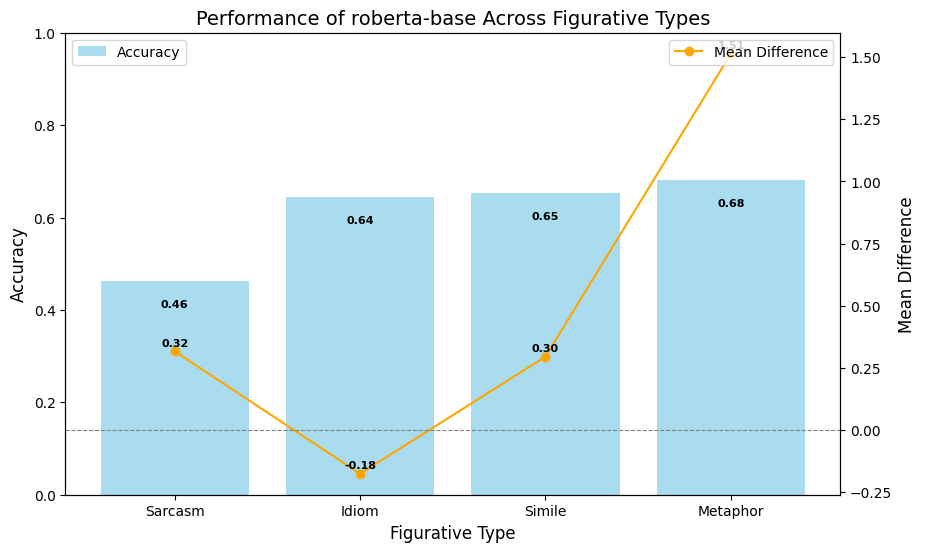

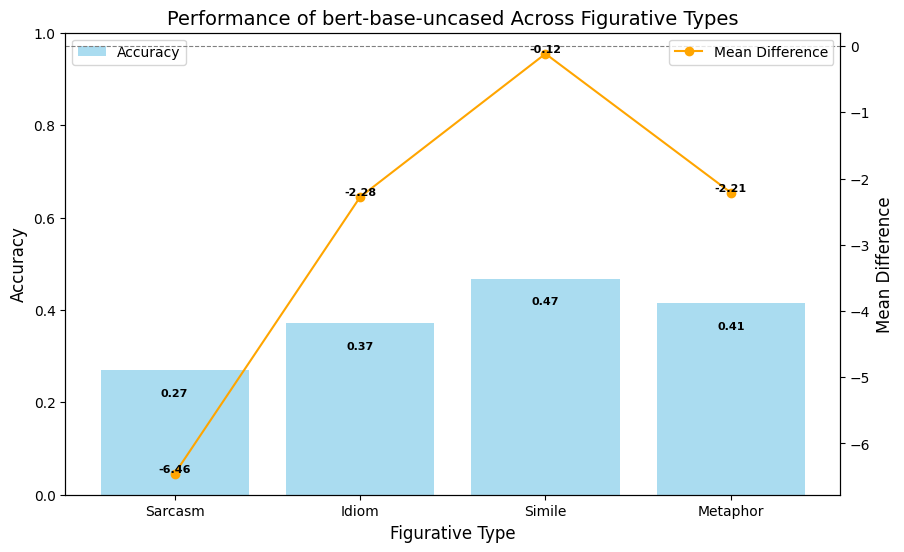

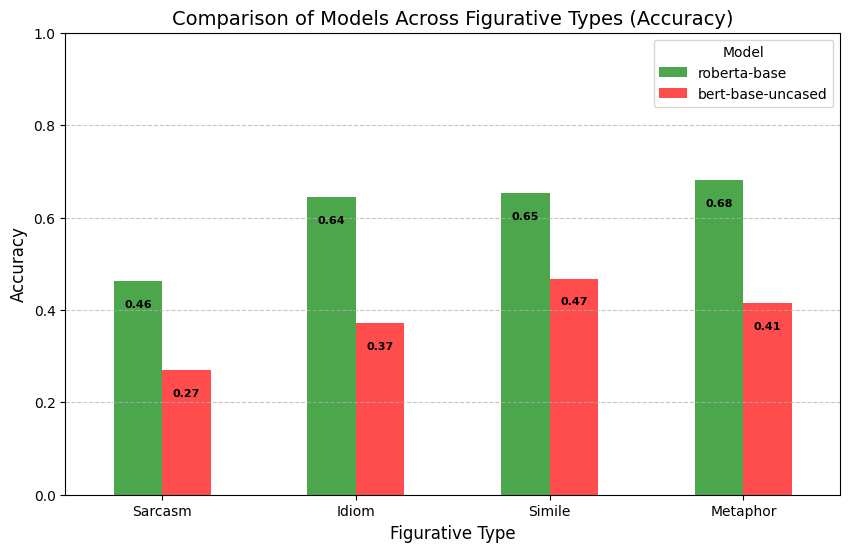


Mean Difference Dictionary:
{'roberta-base': {'Sarcasm': 0.31661676983664055, 'Idiom': -0.17599877167716235, 'Simile': 0.2951150806815322, 'Metaphor': 1.5140135609686027}, 'bert-base-uncased': {'Sarcasm': -6.457479320784195, 'Idiom': -2.27985783754769, 'Simile': -0.11528885305224366, 'Metaphor': -2.2135095163680156}}


In [ ]:
#Defining the pre-trained models to evaluate
models_to_evaluate=["roberta-base", "bert-base-uncased"]

#Defining a dictionary to store the results for each model
results_by_model={}

#Defining a function to evaluate contrastive pairs for a given figurative language type
def evaluate_contrastive_pairs(figurative_type, dataset, tokenizer, model):
    """
    Evaluates contrastive pairs (figurative vs literal) for a given figurative language type.

    Args:
        figurative_type (str): The type of figurative language.
        dataset (pd.DataFrame): The input dataset containing the figurative language data.
        tokenizer (AutoTokenizer): Pretrained tokenizer.
        model (AutoModelForMaskedLM): Pretrained masked language model.

    Returns:
        dict: A dictionary containing evaluation metrics and results summary.
    """
    #Filtering rows based on the figurative type
    filtered_data=dataset[dataset["type"]==figurative_type]

    #Filling missing values and converting to strings
    filtered_data["hypothesis"]=filtered_data["hypothesis"].fillna("N/A").astype(str)
    filtered_data["explanation"]=filtered_data["explanation"].fillna("N/A").astype(str)

    #Creating contrastive pairs: Figurative (hypothesis) vs Literal (explanation)
    contrastive_data={
        "figurative": filtered_data["hypothesis"].tolist(),
        "literal": filtered_data["explanation"].tolist()
    }

    #Converting to Hugging Face Dataset
    contrastive_dataset=Dataset.from_dict(contrastive_data)

    #Defining a function to compute sentence likelihood
    def compute_sentence_likelihood(sentence, tokenizer, model):
        inputs=tokenizer(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs=model(**inputs)
        logits=outputs.logits
        token_ids=inputs["input_ids"]
        token_probs=torch.nn.functional.softmax(logits, dim=-1)

        #Computing token-wise likelihood
        likelihood=0
        for i, token_id in enumerate(token_ids[0]):
            likelihood+=token_probs[0, i, token_id].log()
        return likelihood.item()

    #Evaluating figurative contrastive pairs
    results=[]
    for pair in contrastive_dataset:
        figurative_sentence=pair["figurative"]
        literal_sentence=pair["literal"]

        figurative_score=compute_sentence_likelihood(figurative_sentence, tokenizer, model)
        literal_score=compute_sentence_likelihood(literal_sentence, tokenizer, model)

        preferred="Literal" if literal_score>figurative_score else "Figurative"
        results.append({
            "Figurative Sentence": figurative_sentence,
            "Literal Sentence": literal_sentence,
            "Figurative Score": figurative_score,
            "Literal Score": literal_score,
            "Model Preference": preferred
        })

    #Displaying results for the first 5 pairs
    print(f"Results for {figurative_type} (First 5 Examples):")
    for i, result in enumerate(results[:5]):
        print(f"Pair {i+1}:")
        print(f"  Figurative: {result['Figurative Sentence']}")
        print(f"  Literal: {result['Literal Sentence']}")
        print(f"  Figurative Score: {result['Figurative Score']:.4f}")
        print(f"  Literal Score: {result['Literal Score']:.4f}")
        print(f"  Model Preference: {result['Model Preference']}")
        print()

    #Extracting scores
    figurative_scores=[result["Figurative Score"] for result in results]
    literal_scores=[result["Literal Score"] for result in results]

    #Log-Likelihood comparison
    differences=np.array(figurative_scores)-np.array(literal_scores)

    #Average difference (positive indicates preference for figurative, negative for literal)
    mean_difference=np.mean(differences)

    #Accuracy of preferences
    #Ground truth: 1 for figurative preferred, 0 for literal preferred
    ground_truth=[1]*len(results)  #Assuming figurative is preferred as ground truth
    predictions=[1 if s>l else 0 for s, l in zip(figurative_scores, literal_scores)]
    accuracy=accuracy_score(ground_truth, predictions)

    #Confidence scores
    confidence_scores=np.abs(differences)
    mean_confidence=np.mean(confidence_scores)

    #Statistical significance testing
    #T-test for mean difference between figurative and literal scores
    t_stat, p_value_ttest=ttest_ind(figurative_scores, literal_scores)

    #Wilcoxon signed-rank test (non-parametric)
    w_stat, p_value_wilcoxon=wilcoxon(figurative_scores, literal_scores)

    #Score distribution analysis
    figurative_mean=np.mean(figurative_scores)
    figurative_std=np.std(figurative_scores)
    literal_mean=np.mean(literal_scores)
    literal_std=np.std(literal_scores)

    #Results summary
    results_summary={
        "Mean Difference": mean_difference,
        "Accuracy": accuracy,
        "Mean Confidence": mean_confidence,
        "Figurative Mean": figurative_mean,
        "Literal Mean": literal_mean,
        "T-test P-value": p_value_ttest,
        "Wilcoxon P-value": p_value_wilcoxon,
        "Figurative Std Dev": figurative_std,
        "Literal Std Dev": literal_std
    }

    #Displaying results summary
    print(f"Results Summary for {figurative_type}:")
    for metric, value in results_summary.items():
        print(f"{metric}: {value:.4f}")

    return results_summary

#Applying "evaluate_contrastive_pairs" function on flute_train
figurative_types=["Sarcasm", "Idiom", "Simile", "Metaphor"]

for model_name in models_to_evaluate:
    print(f"\n{'=' * 50}\nEvaluating model: {model_name}\n{'=' * 50}")

    #Loading the tokenizer and model for the current model_name
    tokenizer=AutoTokenizer.from_pretrained(model_name)
    model=AutoModelForMaskedLM.from_pretrained(model_name)
    model.eval()  #Setting the model to evaluation mode

    #Defining a dictionary to store results for each figurative type for the current model
    summaries={}

    for figurative_type in figurative_types:
        print(f"\nEvaluating {figurative_type} for {model_name}")
        summaries[figurative_type]=evaluate_contrastive_pairs(figurative_type, flute_train, tokenizer, model)

    #Storing results for this model
    results_by_model[model_name]=summaries

#Printing the results
print("\nFinal Results for All Models:")
for model_name, results in results_by_model.items():
    print(f"\n{'=' * 50}\nResults for Model: {model_name}\n{'=' * 50}")
    for figurative_type, summary in results.items():
        print(f"\nFigurative Type: {figurative_type}")
        for metric, value in summary.items():
            print(f"{metric}: {value:.4f}")

#Converting results into a dataFrame for visualization
data=[]
for model, figurative_results in results_by_model.items():
    for figurative_type, metrics in figurative_results.items():
        data.append({
            "Model": model,
            "Figurative Type": figurative_type,
            "Accuracy": metrics["Accuracy"],
            "Mean Difference": metrics["Mean Difference"]
        })
df=pd.DataFrame(data)

#Visualizing individual model performance
def plot_individual_model(df, model_name):
    model_data=df[df["Model"]==model_name]
    figurative_types=model_data["Figurative Type"]
    accuracies=model_data["Accuracy"]
    mean_differences=model_data["Mean Difference"]

    fig, ax1=plt.subplots(figsize=(10,6))

    #Bar plot for accuracy
    bars=ax1.bar(figurative_types, accuracies, color="skyblue", label="Accuracy", alpha=0.7)
    ax1.set_ylabel("Accuracy", fontsize=12)
    ax1.set_xlabel("Figurative Type", fontsize=12)
    ax1.set_title(f"Performance of {model_name} Across Figurative Types", fontsize=14)
    ax1.set_ylim(0,1)
    ax1.legend(loc="upper left")

    #Adding values inside bars
    for bar in bars:
        height=bar.get_height()
        ax1.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}", ha="center", va="center", color="black", fontsize=8, fontweight="bold")

    #Line plot for mean difference
    ax2=ax1.twinx()
    ax2.plot(figurative_types, mean_differences, color="orange", marker="o", label="Mean Difference")
    ax2.set_ylabel("Mean Difference", fontsize=12)
    ax2.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax2.legend(loc="upper right")

    #Adding values on top of the points in the line plot
    for i, value in enumerate(mean_differences):
        ax2.text(i, value+0.02, f"{value:.2f}", ha="center", color="black", fontsize=8, fontweight="bold")

    plt.show()

#Visualizing the comparison between models
def compare_models(df):
    pivot_df=df.pivot(index="Figurative Type", columns="Model", values="Accuracy")
    figurative_order=["Sarcasm", "Idiom", "Simile", "Metaphor"]
    pivot_df=pivot_df.reindex(figurative_order)
    column_order=["roberta-base", "bert-base-uncased"]
    pivot_df=pivot_df[column_order]
    ax=pivot_df.plot(kind="bar", figsize=(10,6), color=["green", "red"], alpha=0.7)
    plt.title("Comparison of Models Across Figurative Types (Accuracy)", fontsize=14)
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel("Figurative Type", fontsize=12)
    plt.ylim(0,1)
    plt.xticks(rotation=0)
    plt.legend(title="Model")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    #Adding values inside bars
    for container in ax.containers:
        for bar in container:
            height=bar.get_height()
            ax.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
                    ha="center", va="center", color="black", fontsize=8, fontweight="bold")

    plt.show()

#Plot performance of each model
for model_name in models_to_evaluate:
    plot_individual_model(df, model_name)

#Plot comparison of models
compare_models(df)

#Extracting "Mean Difference" for all models and figurative types
mean_difference_dict={}

for model_name, figurative_results in results_by_model.items():
    mean_difference_dict[model_name]={}
    for figurative_type, metrics in figurative_results.items():
        mean_difference_dict[model_name][figurative_type]=metrics["Mean Difference"]

#Printing the "Mean Difference" dictionary
print("\nMean Difference Dictionary:")
print(mean_difference_dict)

### **Model Training and Evaluation Process for ROBERTA and BERT Models**


Processing Model: roberta-base



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing data for roberta-base...


Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


dict_keys(['input_ids', 'attention_mask'])
Setting training arguments for roberta-base...
Initializing Trainer for roberta-base...
Training roberta-base...


Epoch,Training Loss,Validation Loss
1,No log,0.132586
2,0.287200,0.113678


Epoch,Training Loss,Validation Loss
1,No log,0.132586
2,0.287200,0.113678
3,0.068900,0.098025
4,0.019700,0.104894
5,0.019700,0.087026


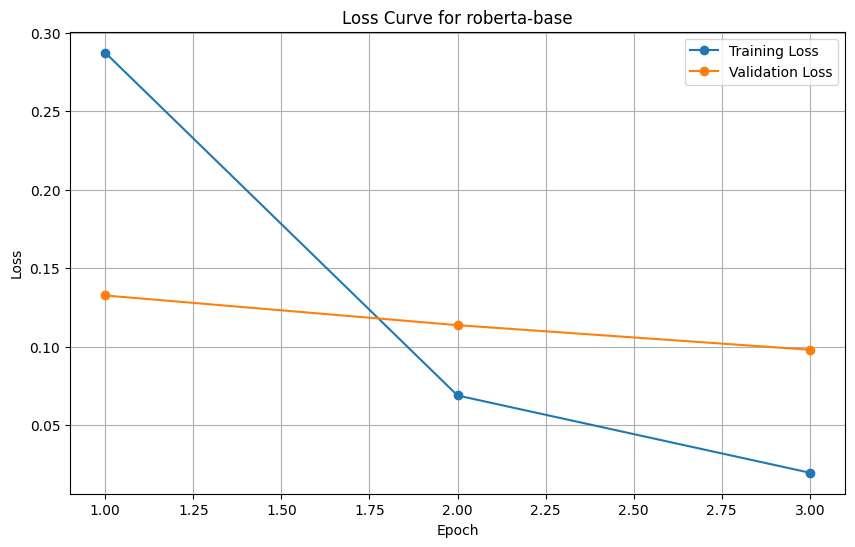

Evaluating roberta-base on Validation Set...


{'eval_loss': 0.08702555298805237, 'eval_runtime': 4.4224, 'eval_samples_per_second': 340.768, 'eval_steps_per_second': 21.482, 'epoch': 5.0}
Evaluating roberta-base on Test Set...
{'eval_loss': 1.8136310577392578, 'eval_runtime': 4.3868, 'eval_samples_per_second': 341.476, 'eval_steps_per_second': 21.428, 'epoch': 5.0}
Generating predictions for roberta-base...
Class Accuracies for roberta-base: {0: 0.6213333333333333, 1: 0.944, 2: 0.996, 3: 0.9354838709677419}


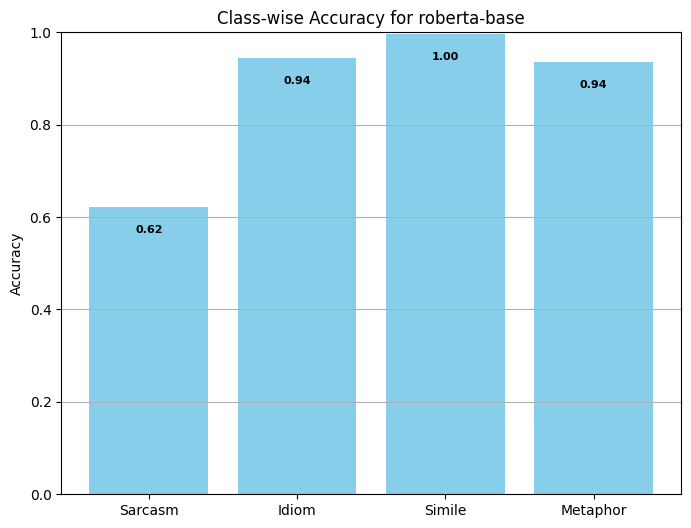

Accuracy for roberta-base: 0.79
Classification Report for roberta-base:
                    precision    recall  f1-score   support

           Sarcasm       1.00      0.62      0.77       750
             Idiom       0.95      0.94      0.95       250
            Simile       0.97      1.00      0.98       250
          Metaphor       0.96      0.94      0.95       248
CreativeParaphrase       0.00      0.00      0.00         0

          accuracy                           0.79      1498
         macro avg       0.77      0.70      0.73      1498
      weighted avg       0.98      0.79      0.86      1498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


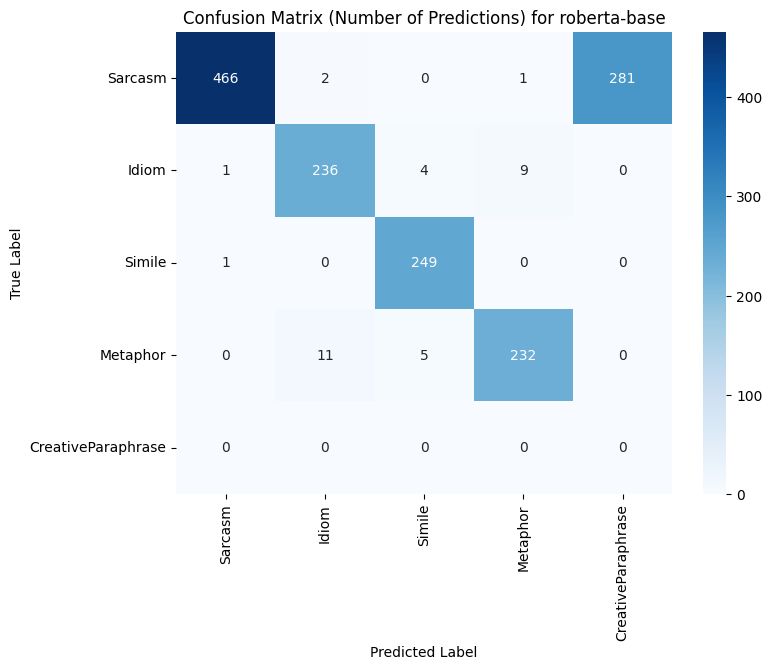

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


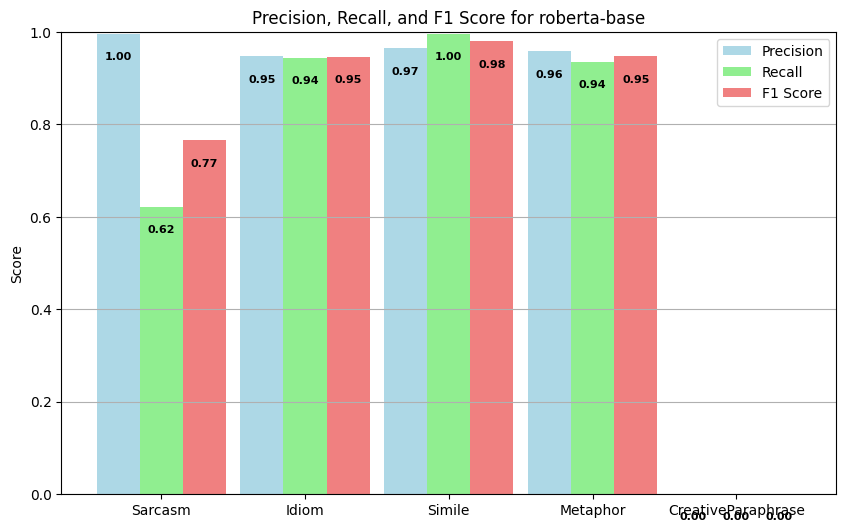

Average BLEURT Score for roberta-base: 0.5155


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore F1 for roberta-base: 0.9571


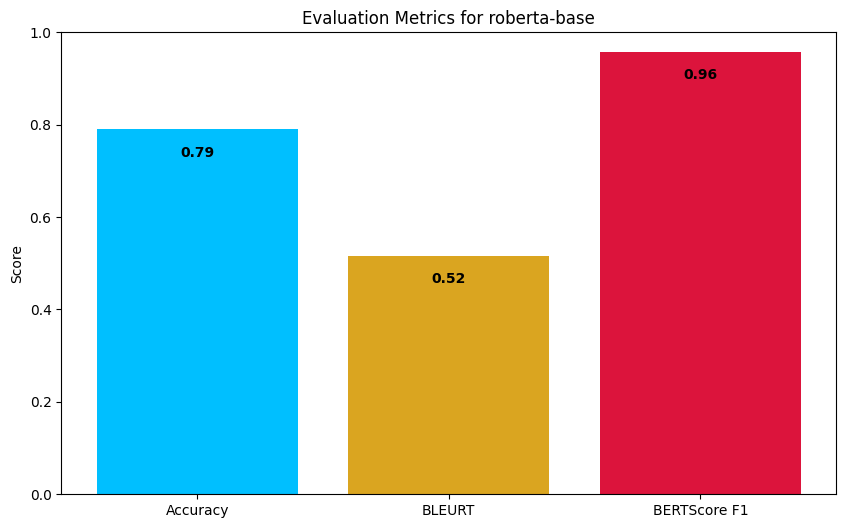

Total misclassified examples for roberta-base: 315/1498
Sample Misclassified Examples for roberta-base: [(19, "I was really excited to inherit my mom's old car but when I got it, I realized the trunk leaked", 'Mismatched Prediction', 0, 4), (23, 'The fact that the price for the part I need for my computer went up 10% right before I decided to buy it made me furious', 'Mismatched Prediction', 0, 4), (25, 'I get really pissed off when my husband leaves his dirty clothes on the floor', 'Mismatched Prediction', 0, 4), (41, "I was out yesterday with a shirt that had a huge hole in the back and totally didn't realize it until a stranger pointed it out", 'Mismatched Prediction', 0, 4), (47, 'Heard gunshots on my street and freaked out, barricaded myself in my room, and texted all my friends.', 'Mismatched Prediction', 0, 4)]
Example 19:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched Prediction
  - Hypothesis: I was really excited to inherit my mom's ol

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing data for bert-base-uncased...


Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Setting training arguments for bert-base-uncased...
Initializing Trainer for bert-base-uncased...
Training bert-base-uncased...


Epoch,Training Loss,Validation Loss
1,No log,0.120450
2,0.269200,0.102601
3,0.039100,0.098403
4,0.006600,0.088269
5,0.006600,0.086937


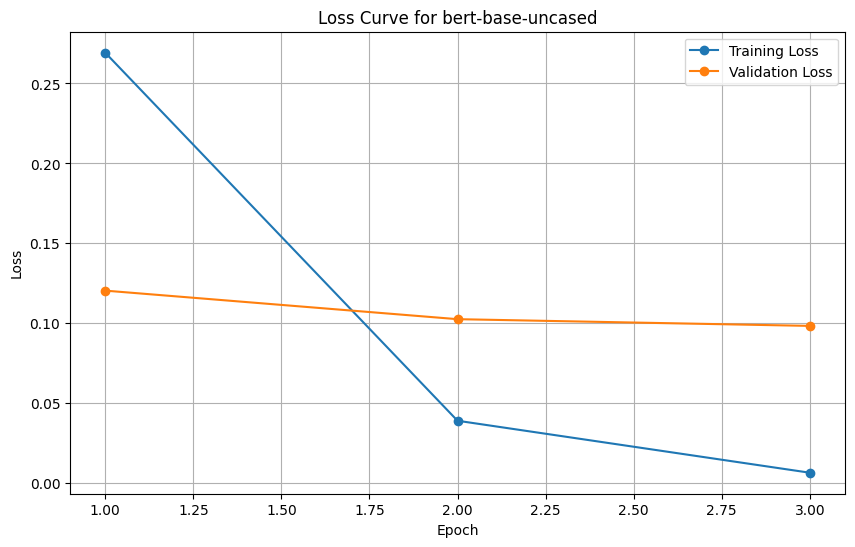

Evaluating bert-base-uncased on Validation Set...


{'eval_loss': 0.0869373008608818, 'eval_runtime': 5.1188, 'eval_samples_per_second': 294.404, 'eval_steps_per_second': 18.559, 'epoch': 5.0}
Evaluating bert-base-uncased on Test Set...
{'eval_loss': 1.820013403892517, 'eval_runtime': 5.1752, 'eval_samples_per_second': 289.459, 'eval_steps_per_second': 18.164, 'epoch': 5.0}
Generating predictions for bert-base-uncased...
Class Accuracies for bert-base-uncased: {0: 0.6146666666666667, 1: 0.92, 2: 0.992, 3: 0.9395161290322581}


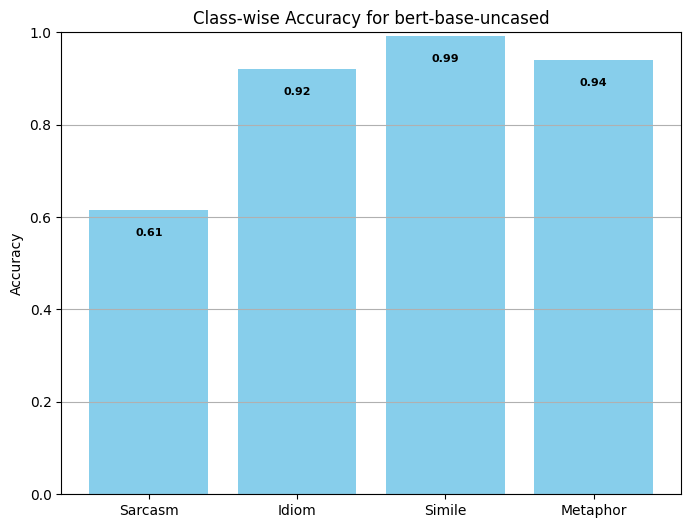

Accuracy for bert-base-uncased: 0.78
Classification Report for bert-base-uncased:
                    precision    recall  f1-score   support

           Sarcasm       0.99      0.61      0.76       750
             Idiom       0.95      0.92      0.93       250
            Simile       0.98      0.99      0.99       250
          Metaphor       0.94      0.94      0.94       248
CreativeParaphrase       0.00      0.00      0.00         0

          accuracy                           0.78      1498
         macro avg       0.77      0.69      0.72      1498
      weighted avg       0.97      0.78      0.86      1498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


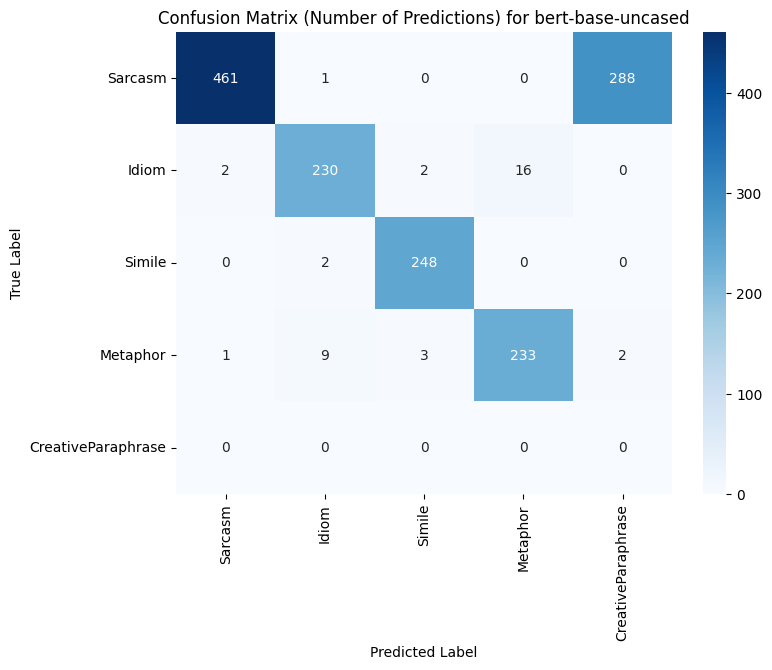

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


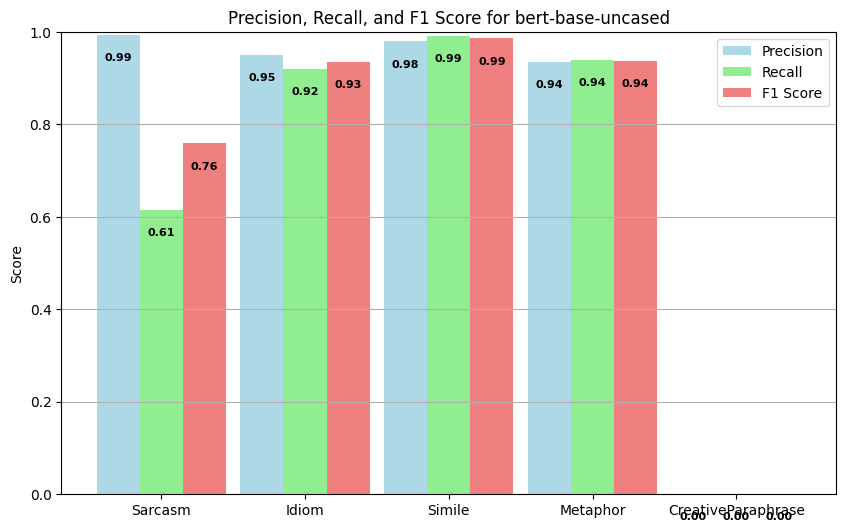

Average BLEURT Score for bert-base-uncased: 0.4974
Average BERTScore F1 for bert-base-uncased: 0.9557


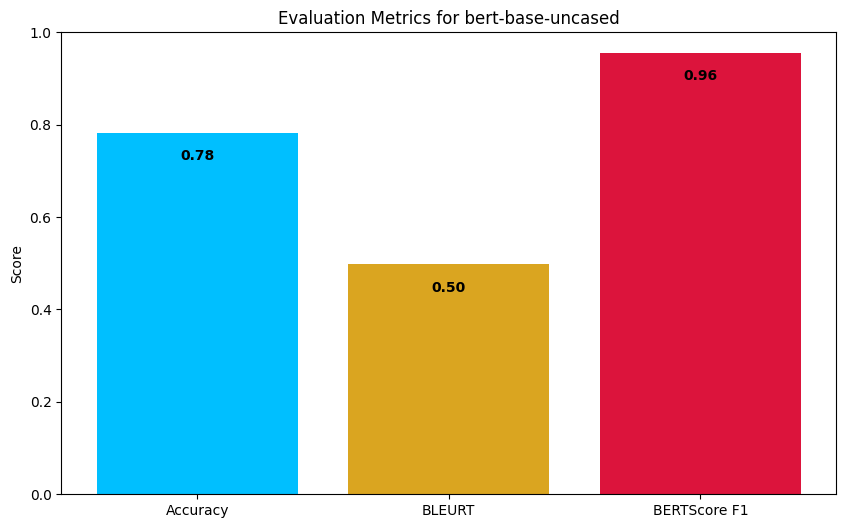

Total misclassified examples for bert-base-uncased: 326/1498
Sample Misclassified Examples for bert-base-uncased: [(17, "It's amazing that my boss takes advantage of me being a hard worker and never appreciates my efforts", 'Mismatched Prediction', 0, 4), (19, "I was really excited to inherit my mom's old car but when I got it, I realized the trunk leaked", 'Mismatched Prediction', 0, 4), (23, 'The fact that the price for the part I need for my computer went up 10% right before I decided to buy it made me furious', 'Mismatched Prediction', 0, 4), (25, 'I get really pissed off when my husband leaves his dirty clothes on the floor', 'Mismatched Prediction', 0, 4), (41, "I was out yesterday with a shirt that had a huge hole in the back and totally didn't realize it until a stranger pointed it out", 'Mismatched Prediction', 0, 4)]
Example 17:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched Prediction
  - Hypothesis: It's amazing that my boss takes ad

,Model,Accuracy,BLEURT,BERTScore F1
0,roberta-base,0.789720,0.515463,0.957065
1,bert-base-uncased,0.782377,0.497426,0.955657


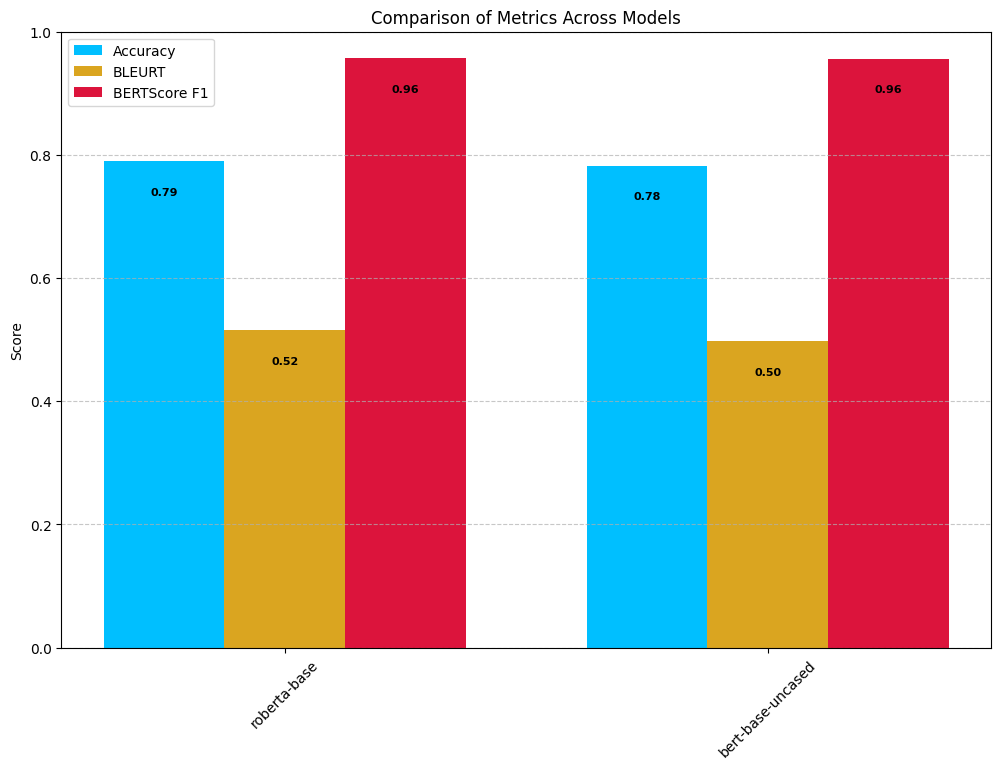


Model Performance Dictionary:
{'roberta-base': {'Accuracy': 0.7897196261682243, 'BLEURT': 0.5154625765074079, 'BERTScore F1': 0.9570651478140313}, 'bert-base-uncased': {'Accuracy': 0.7823765020026703, 'BLEURT': 0.49742583156586967, 'BERTScore F1': 0.9556567208948378}}


In [ ]:
#Converting pandas dataFrames to hugging face datasets
hf_flute_train=Dataset.from_pandas(flute_train)
hf_flute_val=Dataset.from_pandas(flute_val)
hf_test_dataset=Dataset.from_pandas(test_df)

#List of the models
model_names=[
    "roberta-base",
    "bert-base-uncased"
]

#Type mapping
type_mapping={"Sarcasm": 0, "Idiom": 1, "Simile": 2, "Metaphor": 3, "CreativeParaphrase": 4}

#Defining a tokenization function
def tokenize_function(dataframe):
    return tokenizer(
        dataframe["premise"],
        dataframe["hypothesis"],
        padding="max_length",
        truncation=True,
        )

#Importing evaluation metrics
bleurt_metric=load("bleurt", "bleurt-large-512")
bertscore_metric=load("bertscore")

#Initializing a list to store performance metrics for all models
model_performance=[]

#Dictionary to store trained trainers for each model
trainers={}

#Dictionary to store misclassified examples for each model
misclassified_per_model={}

#Loop through each model and store its trainer
for model_name in model_names:
    print(f"\n{'='*50}\nProcessing Model: {model_name}\n{'='*50}\n")

    #Setting seed inside the loop for reproducibility in each iteration
    set_seed(101)

    #Loading tokenizer and model
    tokenizer=AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model=AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
    model.gradient_checkpointing_enable()

    #Tokenizing and processing data
    print(f"Tokenizing data for {model_name}...")
    tokenized_flute_train=hf_flute_train.map(tokenize_function, batched=True)
    tokenized_flute_train=tokenized_flute_train.map(lambda x: {"labels": type_mapping[x["type"]]})
    tokenized_flute_train=tokenized_flute_train.remove_columns(["label", "type", "id", "premise", "hypothesis", "explanation", "split", "idiom", "__index_level_0__"])

    tokenized_flute_val=hf_flute_val.map(tokenize_function, batched=True)
    tokenized_flute_val=tokenized_flute_val.map(lambda x: {"labels": type_mapping[x["type"]]})
    tokenized_flute_val=tokenized_flute_val.remove_columns(["label", "type", "id", "premise", "hypothesis", "explanation", "split", "idiom", "__index_level_0__"])

    tokenized_flute_test=hf_test_dataset.map(tokenize_function, batched=True)
    tokenized_flute_test=tokenized_flute_test.map(lambda x: {"labels": type_mapping[x["type"]]})
    tokenized_flute_test=tokenized_flute_test.remove_columns(["label", "type", "id", "premise", "hypothesis", "explanation", "split", "idiom"])

    #Inspecting the tokenizer output
    print(tokenizer("premise", "hypothesis").keys())

    #Defining training arguments
    print(f"Setting training arguments for {model_name}...")
    training_args=TrainingArguments(
        output_dir=f"./results/{model_name}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        save_total_limit=2,
        logging_dir=f"./logs/{model_name}",
        load_best_model_at_end=True,
        fp16=True,
        seed=101,
    )

    #Defining trainer
    print(f"Initializing Trainer for {model_name}...")
    trainer=Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_flute_train,
        eval_dataset=tokenized_flute_val,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    #Training the model
    print(f"Training {model_name}...")
    trainer.train()

    #Storing the trainer in the dictionary
    trainers[model_name]=trainer

    #Extracting epoch-wise training and evaluation loss
    training_logs=trainer.state.log_history  #Access log history
    training_loss=[log["loss"] for log in training_logs if "loss" in log and "epoch" in log]
    eval_loss=[log["eval_loss"] for log in training_logs if "eval_loss" in log]

    #Checking if logs are available
    if len(training_loss)==0 or len(eval_loss)==0:
      print(f"Warning: No sufficient training or validation loss data for {model_name}. Skipping loss plot.")
    else:
      #Ensuring lengths match
      min_len=min(len(training_loss), len(eval_loss))
      training_loss=training_loss[:min_len]
      eval_loss=eval_loss[:min_len]
      epochs=range(1, len(eval_loss)+1)

    #Ploting the training and evaluation loss
    plt.figure(figsize=(10,6))
    plt.plot(epochs, training_loss[:len(eval_loss)], label="Training Loss", marker="o")  #Adjusting length to match
    plt.plot(epochs, eval_loss, label="Validation Loss", marker="o")
    plt.title(f"Loss Curve for {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    #Evaluating on validation set
    print(f"Evaluating {model_name} on Validation Set...")
    val_results=trainer.evaluate(tokenized_flute_val)
    print(val_results)

    #Evaluating on test set
    print(f"Evaluating {model_name} on Test Set...")
    test_results=trainer.evaluate(tokenized_flute_test)
    print(test_results)

    #Generating predictions and metrics
    print(f"Generating predictions for {model_name}...")
    predictions=trainer.predict(tokenized_flute_test)
    predicted_labels=predictions.predictions.argmax(axis=1)
    true_labels=predictions.label_ids

    #Mapping label indices to class names
    label_to_name_mapping={0:"Sarcasm", 1:"Idiom", 2:"Simile", 3:"Metaphor", 4:"CreativeParaphrase"}

    #Converting predicted labels to corresponding hypothesis texts and defining references for BLEURT, and BERTScore
    predictions_text=[test_df.iloc[i]["hypothesis"] if predicted_labels[i]==true_labels[i] else "Mismatched prediction"
                      for i in range(len(predicted_labels))]
    references=list(test_df["hypothesis"])

    #Getting unique classes in the test set
    unique_classes_in_test=sorted(list(set(true_labels)))

    #Getting class names dynamically from the available labels
    filtered_class_names=[label_to_name_mapping[label] for label in unique_classes_in_test]

    #Per-Class Accuracy (only for classes present in the test set)
    accuracy_per_class={
        label:((np.array(true_labels)==label)&(np.array(predicted_labels)==label)).sum()
        /(np.array(true_labels)==label).sum() if (np.array(true_labels)==label).sum()>0 else 0.0
        for label in unique_classes_in_test}

    print(f"Class Accuracies for {model_name}:", accuracy_per_class)

    #Visualizing bar plot for class accuracy
    plt.figure(figsize=(8,6))
    bars=plt.bar(
        filtered_class_names,
        [accuracy_per_class[label] for label in unique_classes_in_test],
        color="skyblue")
    plt.title(f"Class-wise Accuracy for {model_name}")
    plt.ylabel("Accuracy")
    plt.ylim(0,1)
    plt.grid(axis="y")

    #Adding values inside bars
    for bar in bars:
      height=bar.get_height()
      plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
               ha="center", va="center", color="black", fontsize=8, fontweight="bold")

    plt.show()

    #Overall accuracy
    accuracy=accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy for {model_name}: {accuracy:.2f}")

    #Classification report
    report=classification_report(
        true_labels, predicted_labels, target_names=["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"]
    )
    print(f"Classification Report for {model_name}:\n{report}")

    #Confusion matrix
    cm=confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2, 3, 4])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"],
                yticklabels=["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"])
    plt.title(f"Confusion Matrix (Number of Predictions) for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    #Precision, Recall, and F1-Score bar Chart
    precision, recall, f1, _=precision_recall_fscore_support(true_labels, predicted_labels, labels=[0, 1, 2, 3, 4])
    x=np.arange(len(precision))
    width=0.3

    plt.figure(figsize=(10,6))
    bars1=plt.bar(x-width, precision, width, label="Precision", color="lightblue")
    bars2=plt.bar(x, recall, width, label="Recall", color="lightgreen")
    bars3=plt.bar(x+width, f1, width, label="F1 Score", color="lightcoral")
    plt.xticks(x, ["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"])
    plt.title(f"Precision, Recall, and F1 Score for {model_name}")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.legend()
    plt.grid(axis="y")

    #Adding values inside bars
    for bars in [bars1, bars2, bars3]:
      for bar in bars:
        height=bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
                 ha="center", va="center", color="black", fontsize=8, fontweight="bold")

    plt.show()

    #BLEURT Score
    bleurt_result=bleurt_metric.compute(predictions=predictions_text, references=references)
    avg_bleurt=np.mean(bleurt_result["scores"])
    print(f"Average BLEURT Score for {model_name}: {avg_bleurt:.4f}")

    #BERTScore
    bertscore_result=bertscore_metric.compute(predictions=predictions_text, references=references, lang="en")
    avg_bertscore_f1=np.mean(bertscore_result["f1"])
    print(f"Average BERTScore F1 for {model_name}: {avg_bertscore_f1:.4f}")

    #Saving the performance data for the models
    model_performance.append({
        "Model": model_name, "Accuracy": accuracy, "BLEURT": avg_bleurt, "BERTScore F1": avg_bertscore_f1})

    #Bar plot for BLEURT, BERTScore
    plt.figure(figsize=(10,6))
    metrics=["Accuracy", "BLEURT", "BERTScore F1"]
    colors=[
        "#00BFFF",   #Deep Sky Blue for Accuracy
        "#DAA520",   #Goldenrod for BLEURT
        "#DC143C"    #Crimson for BERTScore F1
        ]

    values=[accuracy, avg_bleurt, avg_bertscore_f1]
    bars=plt.bar(metrics, values, color=colors)
    plt.title(f"Evaluation Metrics for {model_name}")
    plt.ylabel("Score")
    plt.ylim(0,1)

    #Adding values inside bars
    for bar in bars:
      height=bar.get_height()
      plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
             ha="center", va="center", color="black", fontsize=10, fontweight="bold")

    plt.show()

    #Creating a list of misclassified examples with detailed information
    misclassified=[
        (i, test_df.iloc[i]["hypothesis"], "Mismatched Prediction", true, pred)
        for i, (true, pred) in enumerate(zip(true_labels, predicted_labels))
        if true!=pred
    ]

    #Storing the misclassified examples in a dictionary per model
    misclassified_per_model[model_name]=misclassified

    #Printing summary
    print(f"Total misclassified examples for {model_name}: {len(misclassified)}/{len(true_labels)}")
    print(f"Sample Misclassified Examples for {model_name}:", misclassified[:5])

    for idx, ref, pred_text, true, pred in misclassified[:5]:
        print(f"Example {idx}:")
        print(f"  - True Label: {label_to_name_mapping[true]}")
        print(f"  - Predicted Label: {label_to_name_mapping[pred]}")
        print(f"  - Premise: {pred_text}")
        print(f"  - Hypothesis: {ref}")
        print("-"*50)

#Checking stored misclassified examples per model
print("\nChecking Stored Misclassified Examples Per Model:")
for model_name in misclassified_per_model:
    print(f"{model_name}: {len(misclassified_per_model[model_name])} misclassified examples")

#Creating a dataFrame for performance visualization
performance_df=pd.DataFrame(model_performance)

#Displaying performance comparison table
print("Model Performance Comparison Table:")
display(performance_df)

#Comparison bar chart for all metrics across models
metrics=["Accuracy", "BLEURT", "BERTScore F1"]
colors={
    "Accuracy": "#00BFFF",   #Deep Sky Blue
    "BLEURT": "#DAA520",     #Goldenrod
    "BERTScore F1": "#DC143C"  #Crimson
    }

plt.figure(figsize=(12,8))

#Calculating positions for grouped bars
x=np.arange(len(model_names))  #X positions for the models
width=0.25  #Width of each bar

#Plotting each metric for all models
for i, metric in enumerate(metrics):
    bars=plt.bar(
        x+i*width,
        performance_df[metric],
        width=width,
        label=metric,
        color=colors[metric]
    )

    #Adding values inside bars
    for bar in bars:
        height=bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
                 ha="center", va="center", color="black", fontsize=8, fontweight="bold")

#Configuring the plot
plt.xticks(x+width, performance_df["Model"], rotation=45)
plt.ylabel("Score")
plt.title("Comparison of Metrics Across Models")
plt.ylim(0,1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#Converting the model_performance list into a dictionary
model_performance_dict={
    entry["Model"]:{
        "Accuracy": entry["Accuracy"],
        "BLEURT": entry["BLEURT"],
        "BERTScore F1": entry["BERTScore F1"],
    }
    for entry in model_performance
}

#Displaying the resulting dictionary
print("\nModel Performance Dictionary:")
print(model_performance_dict)

### **Error Patterns Analysis**


Analyzing Error Patterns for Model: roberta-base...


Analyzing Error Patterns for Model: bert-base-uncased...


Misclassification Patterns Across Models:
   True Label     Predicted Label  Count              Model
0       Idiom            Metaphor      9       roberta-base
1       Idiom             Sarcasm      1       roberta-base
2       Idiom              Simile      4       roberta-base
3    Metaphor               Idiom     11       roberta-base
4    Metaphor              Simile      5       roberta-base
5     Sarcasm  CreativeParaphrase    281       roberta-base
6     Sarcasm               Idiom      2       roberta-base
7     Sarcasm            Metaphor      1       roberta-base
8      Simile             Sarcasm      1       roberta-base
9       Idiom            Metaphor     16  bert-base-uncased
10      Idiom             Sarcasm      2  bert-base-uncased
11      Idiom              Simile      2  bert-base-uncased
12   Metaphor  CreativeParaphrase      2  bert-base-uncased
13  

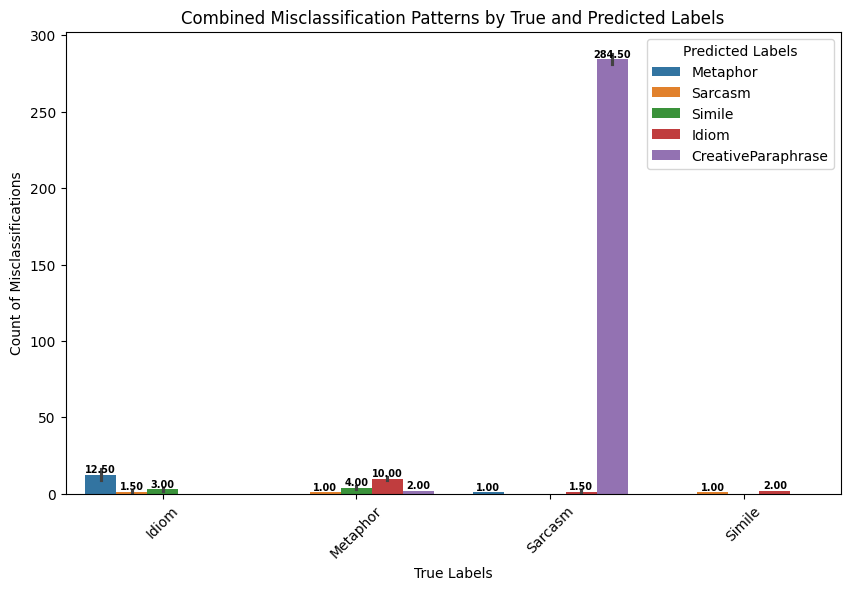

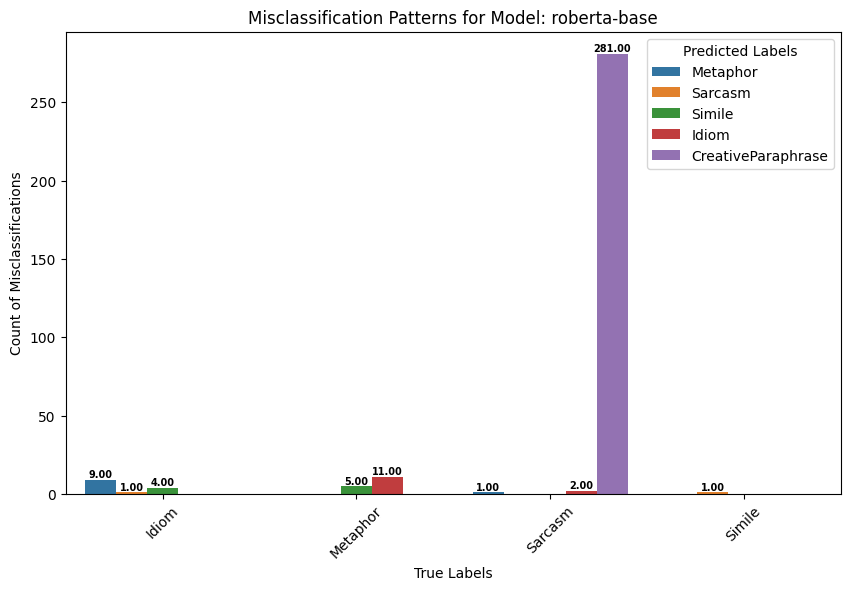

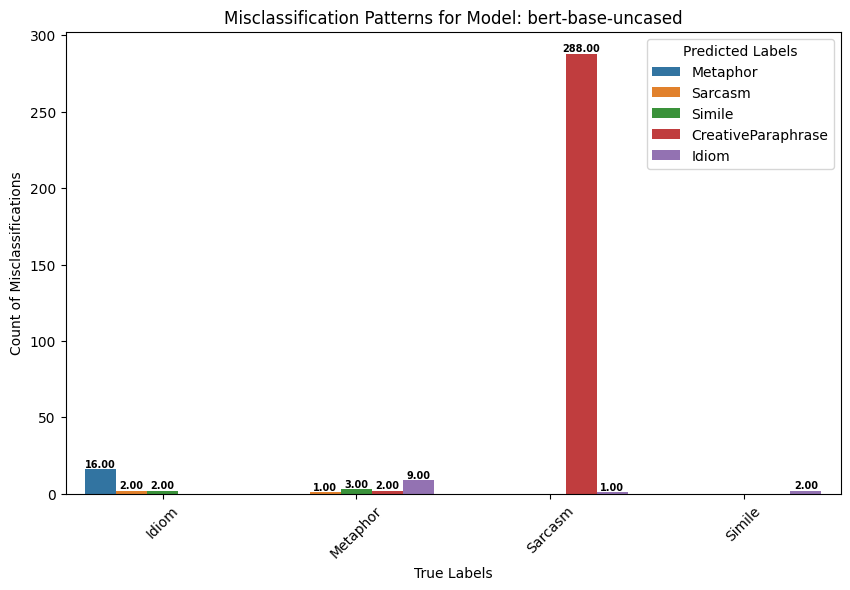

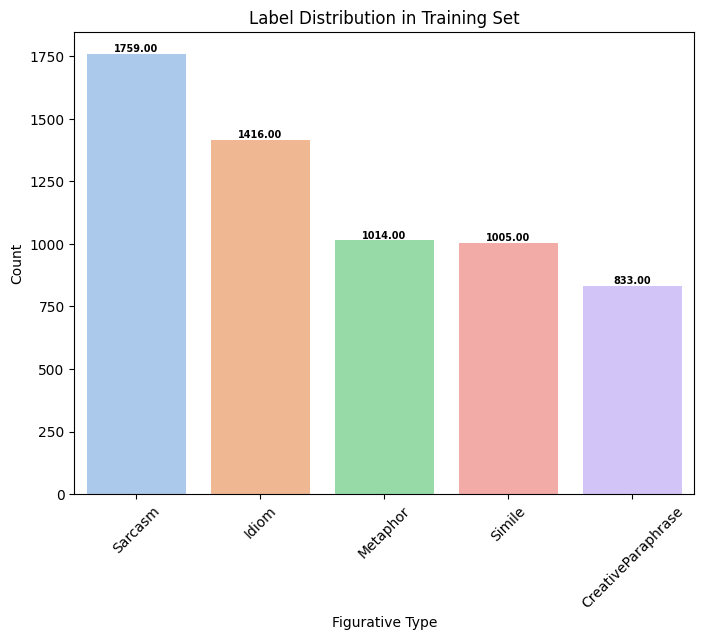

Misclassified examples for roberta-base have been saved to 'misclassified_examples_roberta-base.csv'
Misclassified examples for bert-base-uncased have been saved to 'misclassified_examples_bert-base-uncased.csv'


In [ ]:
#Defining a function to analyze Error Patterns
def analyze_error_patterns(misclassified_examples, model_name):
    """
    Analyze patterns in misclassified example for a given model.

    Args:
        misclassified_examples (list): List of misclassified examples (idx, ref, pred_text, true, pred).
        model_name (str): The name of the model being analyzed.

    Returns:
        pd.DataFrame: A DataFrame showing counts of misclassifications per typefor the given model.
    """
    if not misclassified_examples:  #If the list is empty, return an empty dataframe
        return pd.DataFrame(columns=["True Label", "Predicted Label", "Count", "Model"])

    error_patterns=pd.DataFrame(misclassified_examples, columns=["Index", "Reference", "Prediction", "True Label", "Predicted Label"])

    #Mapping labels to class names
    label_to_name_mapping={0: "Sarcasm", 1: "Idiom", 2: "Simile", 3: "Metaphor", 4: "CreativeParaphrase"}

    error_patterns["True Label"]=error_patterns["True Label"].map(label_to_name_mapping)
    error_patterns["Predicted Label"]=error_patterns["Predicted Label"].map(label_to_name_mapping)

    #Grouping and counting misclassifications
    error_patterns_summary=error_patterns.groupby(["True Label", "Predicted Label"]).size().reset_index(name="Count")
    error_patterns_summary["Model"]=model_name     #Tagging model name

    return error_patterns_summary

#List to store error patterns for both models
all_error_patterns=[]

for model_name in misclassified_per_model:
    if misclassified_per_model[model_name]:  #Ensuring the model has misclassified examples
        print(f"\nAnalyzing Error Patterns for Model: {model_name}...\n")
        model_error_patterns=analyze_error_patterns(misclassified_per_model[model_name], model_name)
        all_error_patterns.append(model_error_patterns)
    else:
        print(f"No misclassified examples found for {model_name}. Skipping error analysis.")

#Combining error patterns from both models into one DataFrame
if all_error_patterns:  #Ensuring there's at least one DataFrame to combine
    combined_error_patterns=pd.concat(all_error_patterns, ignore_index=True)
else:
    combined_error_patterns=pd.DataFrame(columns=["True Label", "Predicted Label", "Count", "Model"])

#Displaying the summary for combined models
if not combined_error_patterns.empty:
    print("\nMisclassification Patterns Across Models:")
    print(combined_error_patterns)

    #Visualizing error patterns
    plt.figure(figsize=(10,6))
    ax=sns.barplot(
        x="True Label",
        y="Count",
        hue="Predicted Label",
        data=combined_error_patterns,
        dodge=True
        )
    plt.title("Combined Misclassification Patterns by True and Predicted Labels")
    plt.xlabel("True Labels")
    plt.ylabel("Count of Misclassifications")
    plt.legend(title="Predicted Labels")
    plt.xticks(rotation=45)

    #Adding values outside the bars
    for p in ax.patches:
        height=p.get_height()
        if height>0:  #Only display values for non-zero bars
            ax.annotate(f"{height:.2f}",
                        (p.get_x()+p.get_width()/2, height),
                        ha="center", va="bottom", fontsize=7, color="black", fontweight="bold")

    plt.show()

    #Creating separate plots for each model
    for model_name in misclassified_per_model.keys():
        #Filtering data for the current model
        model_data=combined_error_patterns[combined_error_patterns["Model"]==model_name]

        if not model_data.empty:
            plt.figure(figsize=(10,6))
            ax=sns.barplot(
                x="True Label",
                y="Count",
                hue="Predicted Label",
                data=model_data,
                dodge=True
            )
            plt.title(f"Misclassification Patterns for Model: {model_name}")
            plt.xlabel("True Labels")
            plt.ylabel("Count of Misclassifications")
            plt.legend(title="Predicted Labels")
            plt.xticks(rotation=45)

            #Adding values outside the bars
            for p in ax.patches:
                height=p.get_height()
                if height>0:  #Only display values for non-zero bars
                    ax.annotate(f"{height:.2f}",
                                (p.get_x()+p.get_width()/2, height),
                                ha="center", va="bottom", fontsize=7, color="black", fontweight="bold")

            plt.show()
        else:
            print(f"\nNo data to plot for {model_name}.")

else:
    print("\nNo misclassification data to visualize.")

#Inspecting Dataset Bias
if "flute_train" in globals():
    #Analyzing label distribution in the training set
    label_distribution=flute_train["type"].value_counts()

    #Visualizing the label distribution
    plt.figure(figsize=(8,6))
    ax=sns.barplot(x=label_distribution.index, y=label_distribution.values, palette="pastel")
    plt.title("Label Distribution in Training Set")
    plt.xlabel("Figurative Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    #Adding values outside the bars
    for p in ax.patches:
        height=p.get_height()
        ax.annotate(f"{height:.2f}",
                    (p.get_x()+p.get_width()/2, height),
                    ha="center", va="bottom", fontsize=7, color="black", fontweight="bold")

    plt.show()
else:
    print("Warning: `flute_train` dataset not found. Ensure that the training dataset is available.")

#Outputting Detailed Reports
for model_name in misclassified_per_model:
    if misclassified_per_model[model_name]:  #Ensuring there are misclassified examples before saving
        misclassified_df=pd.DataFrame(misclassified_per_model[model_name], columns=["Index", "Reference", "Prediction", "True Label", "Predicted Label"])
        filename=f"misclassified_examples_{model_name}.csv"
        misclassified_df.to_csv(filename, index=False)
        print(f"Misclassified examples for {model_name} have been saved to '{filename}'")
    else:
        print(f"No misclassified examples found for {model_name}. Skipping CSV export.")

### **Models' Fine Tuning Process for ROBERTA and BERT Models**

In [ ]:
#Removing rows where the type column equals CreativeParaphrase
flute_df=flute_df[flute_df["type"]!="CreativeParaphrase"]

#Reseting the index after filtering to keep the indexes clean
flute_df.reset_index(drop=True, inplace=True)

#Overviewing the refiend FLUTE dataset
print(flute_df.info())

#Confirming the rows are removed by checking the value counts in the type column
print(flute_df["type"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6484 entries, 0 to 6483
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           6484 non-null   int64 
 1   premise      6484 non-null   object
 2   hypothesis   6484 non-null   object
 3   label        6484 non-null   object
 4   explanation  6480 non-null   object
 5   split        6484 non-null   object
 6   type         6484 non-null   object
 7   idiom        1768 non-null   object
dtypes: int64(1), object(7)
memory usage: 405.4+ KB
None
type
Sarcasm     2216
Idiom       1768
Simile      1250
Metaphor    1250
Name: count, dtype: int64


In [ ]:
#Spliting the refiend FLUTE dataset into training and validation sets
flute_train, flute_val=train_test_split(flute_df, test_size=validation_size, random_state=101)

#Checking the sizes of the splits
print(f"FLUTE Training set size: {len(flute_train)}")
print(f"FLUTE Validation set size: {len(flute_val)}")

FLUTE Training set size: 5187
FLUTE Validation set size: 1297


In [ ]:
#Overviewing the refiend FLUTE Training set
flute_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5187 entries, 5183 to 4959
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5187 non-null   int64 
 1   premise      5187 non-null   object
 2   hypothesis   5187 non-null   object
 3   label        5187 non-null   object
 4   explanation  5183 non-null   object
 5   split        5187 non-null   object
 6   type         5187 non-null   object
 7   idiom        1400 non-null   object
dtypes: int64(1), object(7)
memory usage: 364.7+ KB


In [ ]:
#Monitoring the refiend FLUTE Training set
flute_train.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
5183,6025,I think that one person working alone can achi...,I always believe that two heads are better tha...,Contradiction,The idiom two heads are better than one means ...,train,Idiom,two heads are better than one
1648,1941,She tended to be loud when speaking into a mic...,She tended to blast when speaking into a micro...,Entailment,blast means to speak loudly.,train,Metaphor,NaN
5012,5828,I am so annoyed by my new manager at work beca...,I just love the fact that my new manager at wo...,Contradiction,Having a new manager who is dishonest and untr...,train,Sarcasm,NaN
4470,5190,Even though it had two legs and arms like a hu...,It balanced on two asymmetrical legs and had a...,Entailment,"A scarecrow is a crude imitation of a human, m...",train,Simile,NaN
4844,5632,The event left her memory.,The event engraved itself into her memory.,Contradiction,The word engraved refers something that is per...,train,Metaphor,NaN


In [ ]:
#Reviewing the "type" and "label" columns in the FLUTE Training set after refining
results=analyze_columns(flute_train, ["type", "label"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: type
Number of unique values: 4
Value counts:
type
Sarcasm     1789
Idiom       1400
Simile      1007
Metaphor     991
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    3481
Entailment       1706
Name: count, dtype: int64
--------------------------------------------------


In [ ]:
#Overviewing the refiend FLUTE Validation set
flute_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 1782 to 461
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1297 non-null   int64 
 1   premise      1297 non-null   object
 2   hypothesis   1297 non-null   object
 3   label        1297 non-null   object
 4   explanation  1297 non-null   object
 5   split        1297 non-null   object
 6   type         1297 non-null   object
 7   idiom        368 non-null    object
dtypes: int64(1), object(7)
memory usage: 91.2+ KB


In [ ]:
#Monitoring the refiend FLUTE Validation set
flute_val.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
1782,2092,"My friend Karl had a party, he invited a lot o...",I feel so cherished that my loyal friend Karl ...,Contradiction,Being left out of a party organized by a close...,train,Sarcasm,NaN
4697,5460,"Even though the exterior was small, the interi...",The interior was far bigger than its exterior ...,Contradiction,A rail-road tunnel through a mountain would ha...,train,Simile,NaN
3100,3607,"Every day, I had not nothing but not showing ...","Every day, I had done nothing but walk on eggs...",Contradiction,To walk on eggshells around someone means to a...,train,Idiom,walk on eggshells
6435,7482,The grove only takes the top thirty drama cand...,The grove only takes the top thirty drama cand...,Entailment,To put your best foot forward means to embark ...,train,Idiom,put your best foot forward
5021,5838,Attendees understood that whatever was said pu...,Attendees understood that whatever was said un...,Contradiction,To say something under the rose means to say i...,train,Idiom,under the rose


In [ ]:
#Reviewing the "type" and "label" columns in the FLUTE Validation set after refining
results=analyze_columns(flute_val, ["type", "label"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: type
Number of unique values: 4
Value counts:
type
Sarcasm     427
Idiom       368
Metaphor    259
Simile      243
Name: count, dtype: int64
--------------------------------------------------
Column: label
Number of unique values: 2
Value counts:
label
Contradiction    869
Entailment       428
Name: count, dtype: int64
--------------------------------------------------


Fine-tuning roberta-base...


Map:   0%|          | 0/5187 [00:00<?, ? examples/s]

Map:   0%|          | 0/1297 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.320600,0.116444,0.977641
2,0.081600,0.082606,0.986893
3,0.062400,0.111220,0.984580
4,0.000400,0.080565,0.989206
5,0.004900,0.065195,0.990748
6,0.014100,0.074780,0.991519
7,0.000100,0.074452,0.990748



Extracted Training Loss Values: [0.3206, 0.0816, 0.0624, 0.0167, 0.0004, 0.0049, 0.0141, 0.0029, 0.0001]
Extracted Validation Loss Values: [0.11644390225410461, 0.08260603994131088, 0.11122000962495804, 0.08056480437517166, 0.06519461423158646, 0.07478020340204239, 0.07445161044597626]
Extracted Validation Accuracy Values: [0.9776407093292213, 0.9868928296067849, 0.9845797995373939, 0.9892058596761758, 0.9907478797224364, 0.9915188897455667, 0.9907478797224364]
Fine-tuning bert-base-uncased...


Map:   0%|          | 0/5187 [00:00<?, ? examples/s]

Map:   0%|          | 0/1297 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.284000,0.116198,0.975328
2,0.055600,0.066252,0.989206
3,0.030200,0.093291,0.985351
4,0.001600,0.032587,0.996145
5,0.000200,0.033496,0.996145
6,0.000100,0.035893,0.996145
7,0.000100,0.036278,0.996145



Extracted Training Loss Values: [0.284, 0.0556, 0.0302, 0.0048, 0.0016, 0.0002, 0.0001, 0.0001, 0.0001]
Extracted Validation Loss Values: [0.1161980926990509, 0.06625241786241531, 0.09329144656658173, 0.03258727490901947, 0.033496253192424774, 0.03589272499084473, 0.03627820312976837]
Extracted Validation Accuracy Values: [0.9753276792598303, 0.9892058596761758, 0.9853508095605242, 0.9961449498843485, 0.9961449498843485, 0.9961449498843485, 0.9961449498843485]

Evaluating roberta-base on the Test Set...


Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Accuracy for roberta-base: 0.97

Classification Report for roberta-base:
              precision    recall  f1-score   support

     Sarcasm       0.99      1.00      1.00       750
       Idiom       0.95      0.91      0.93       250
      Simile       0.95      0.99      0.97       250
    Metaphor       0.93      0.93      0.93       248

    accuracy                           0.97      1498
   macro avg       0.96      0.96      0.96      1498
weighted avg       0.97      0.97      0.97      1498

BLEURT Score for roberta-base: 0.9606
BERTScore F1 for roberta-base: 0.9941
Class Accuracies for roberta-base: {0: 0.9973333333333333, 1: 0.908, 2: 0.992, 3: 0.9274193548387096}


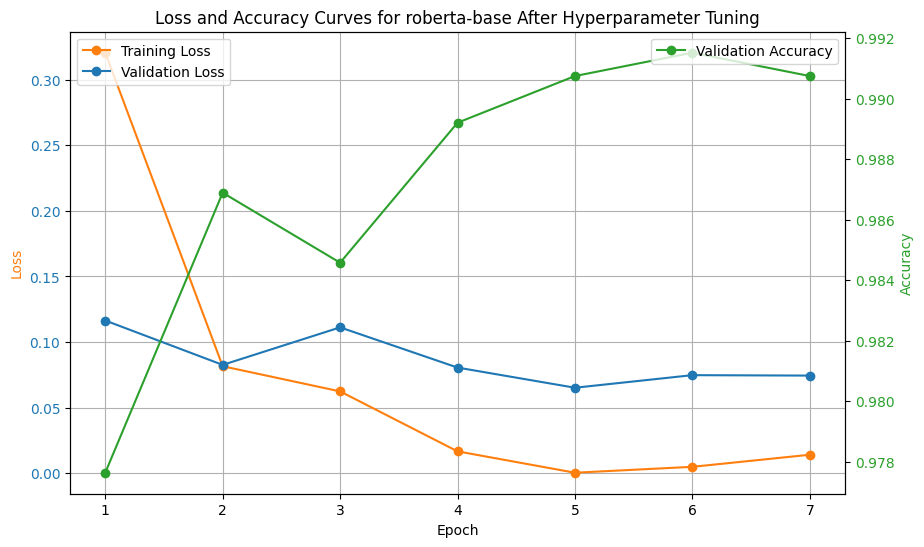

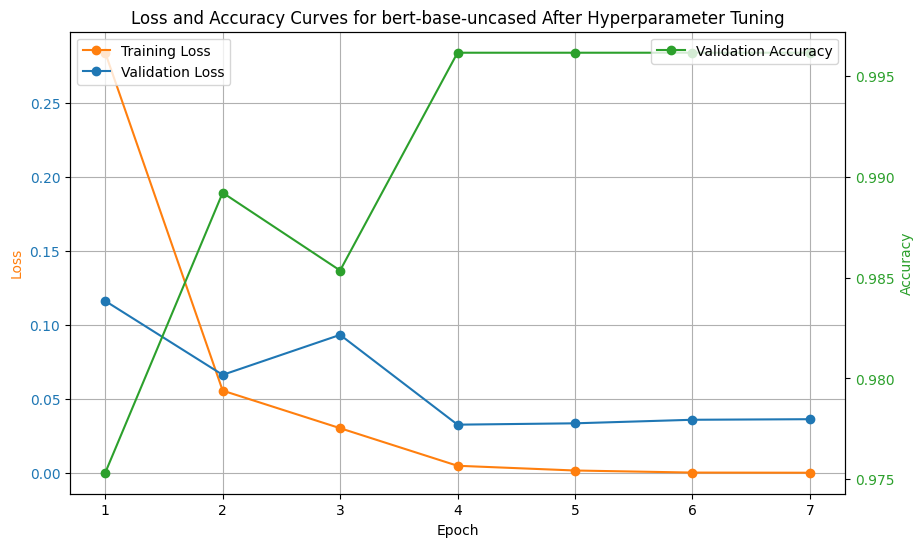

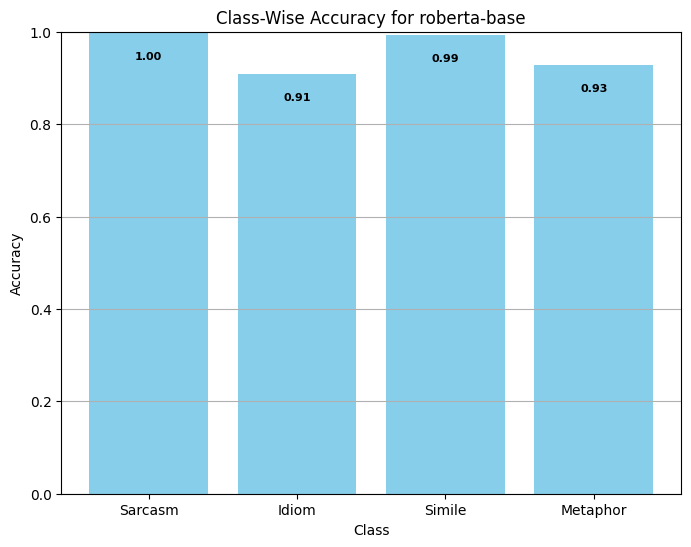

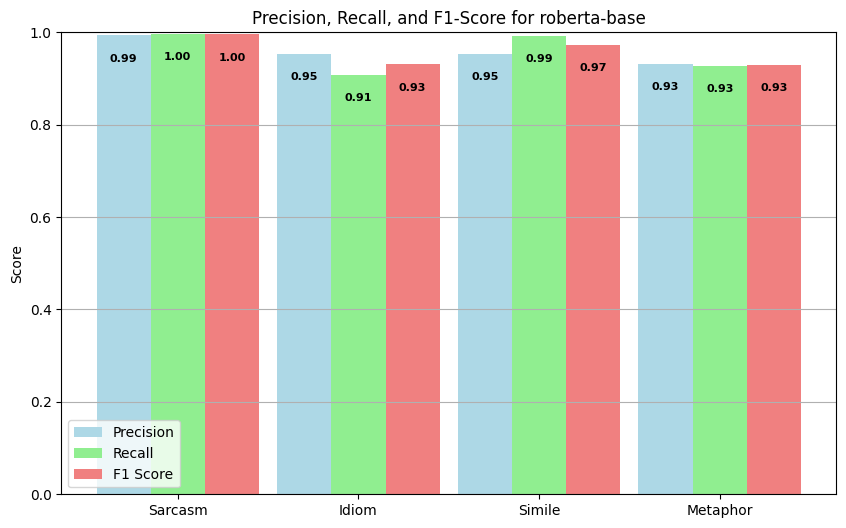

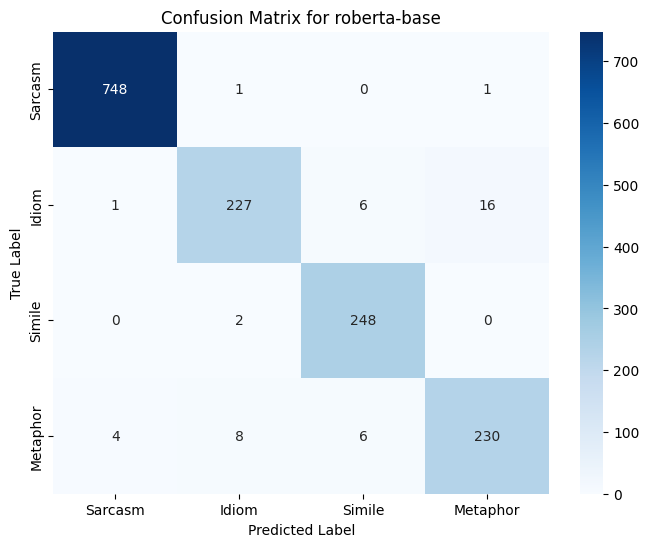

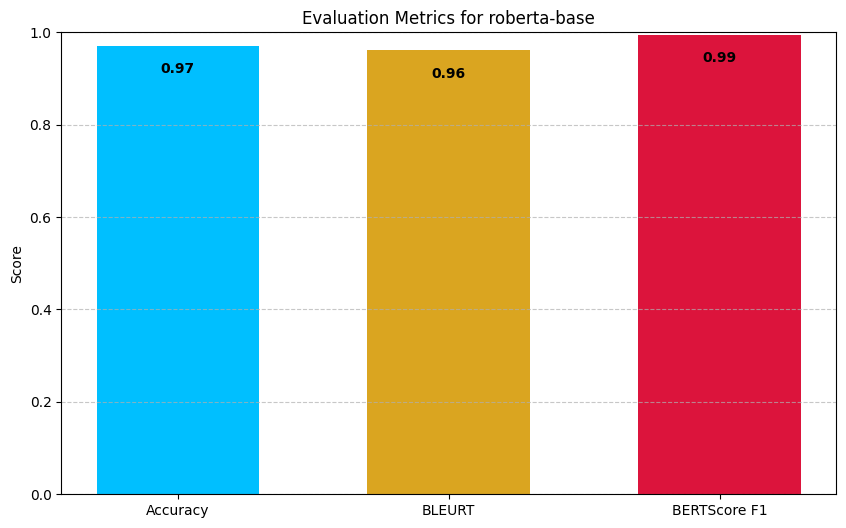

Total misclassified examples for roberta-base: 45/1498
Sample Misclassified Examples for roberta-base: [(51, 1, 2), (57, 3, 2), (117, 1, 2), (197, 3, 2), (298, 3, 1)]
Detailed Misclassified Examples for roberta-base:
Example 51:
  - True Label: Idiom
  - Predicted Label: Simile
  - Premise: Mismatched prediction
  - Hypothesis: The atmosphere was very peculiar and they all seem to get on like a house on fire.
--------------------------------------------------
Example 57:
  - True Label: Metaphor
  - Predicted Label: Simile
  - Premise: Mismatched prediction
  - Hypothesis: His friend was very tall and he looked like a chess piece beside him.
--------------------------------------------------
Example 117:
  - True Label: Idiom
  - Predicted Label: Simile
  - Premise: Mismatched prediction
  - Hypothesis: The atmosphere was very peculiar and they all seem to get on like a house on fire.
--------------------------------------------------
Example 197:
  - True Label: Metaphor
  - Predicted

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Accuracy for bert-base-uncased: 0.97

Classification Report for bert-base-uncased:
              precision    recall  f1-score   support

     Sarcasm       1.00      0.99      0.99       750
       Idiom       0.94      0.93      0.94       250
      Simile       0.98      0.99      0.99       250
    Metaphor       0.91      0.94      0.92       248

    accuracy                           0.97      1498
   macro avg       0.96      0.96      0.96      1498
weighted avg       0.97      0.97      0.97      1498

BLEURT Score for bert-base-uncased: 0.9640
BERTScore F1 for bert-base-uncased: 0.9943
Class Accuracies for bert-base-uncased: {0: 0.9906666666666667, 1: 0.928, 2: 0.992, 3: 0.9354838709677419}


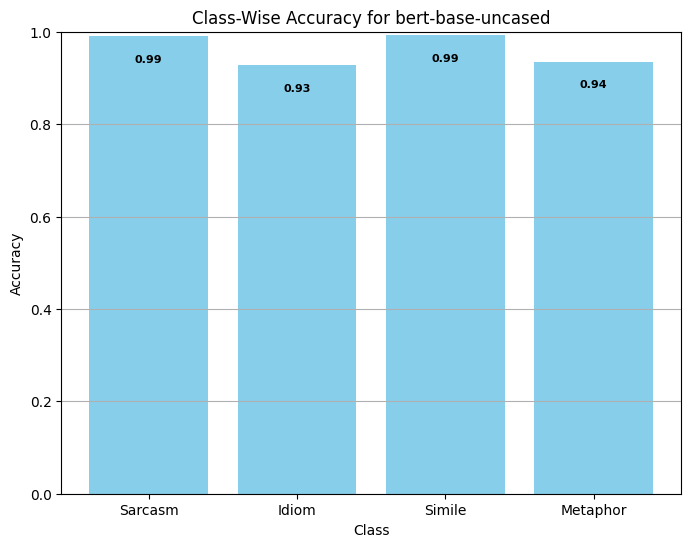

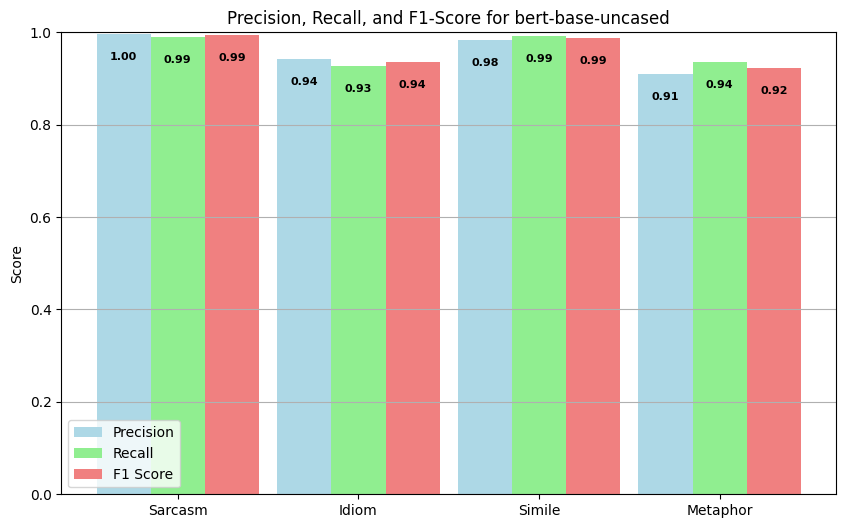

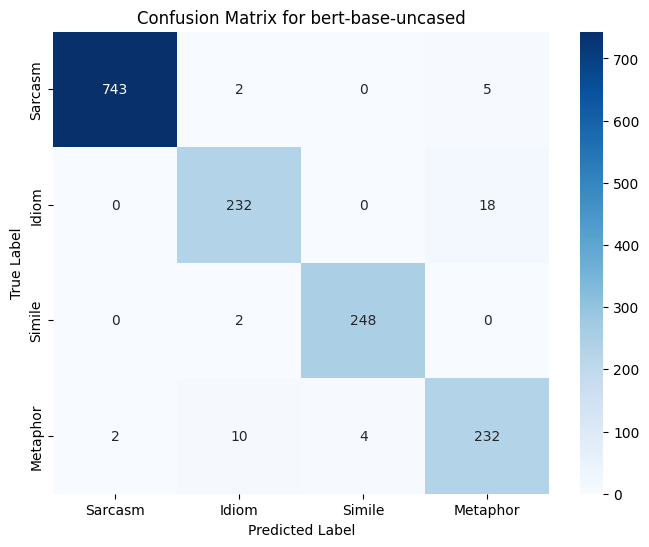

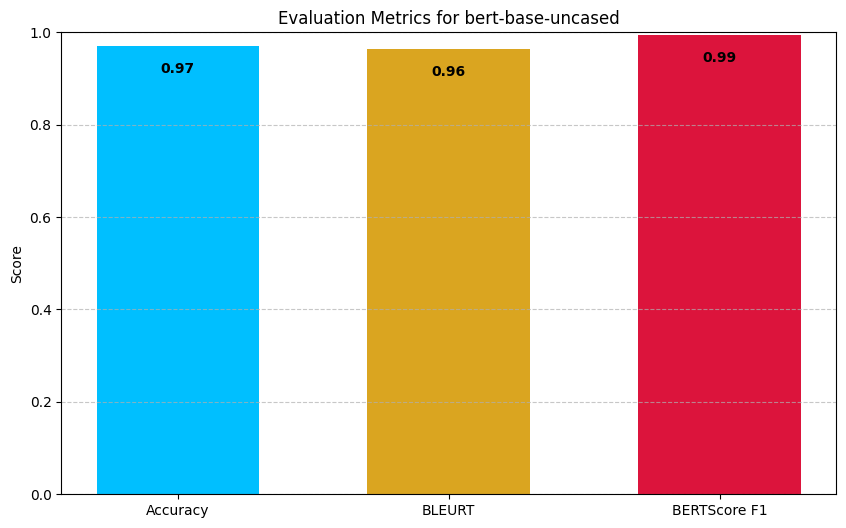

Total misclassified examples for bert-base-uncased: 43/1498
Sample Misclassified Examples for bert-base-uncased: [(57, 3, 2), (95, 3, 1), (155, 1, 3), (258, 0, 1), (298, 3, 1)]
Detailed Misclassified Examples for bert-base-uncased:
Example 57:
  - True Label: Metaphor
  - Predicted Label: Simile
  - Premise: Mismatched prediction
  - Hypothesis: His friend was very tall and he looked like a chess piece beside him.
--------------------------------------------------
Example 95:
  - True Label: Metaphor
  - Predicted Label: Idiom
  - Premise: Mismatched prediction
  - Hypothesis: The sun was a toddler insistently refusing to go to bed: It was past eight thirty and still light.
--------------------------------------------------
Example 155:
  - True Label: Idiom
  - Predicted Label: Metaphor
  - Premise: Mismatched prediction
  - Hypothesis: When beheaded, his fallen head continued to sing the praises of god.
--------------------------------------------------
Example 258:
  - True Label: S

,Model,Accuracy,BLEURT,BERTScore F1
0,roberta-base,0.969960,0.960581,0.994075
1,bert-base-uncased,0.971295,0.964045,0.994310


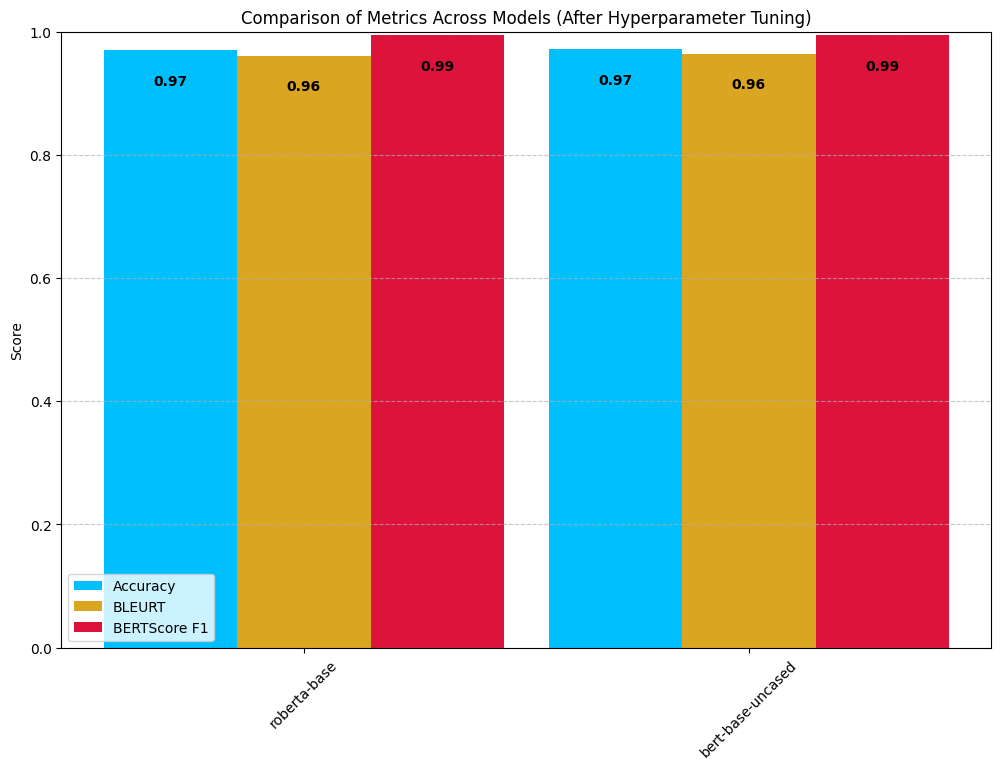


Final Tuned Model Performance Dictionary:
{'roberta-base': {'Accuracy': 0.9699599465954606, 'BLEURT': 0.9605811264152043, 'BERTScore F1': 0.9940753946396633}, 'bert-base-uncased': {'Accuracy': 0.9712950600801068, 'BLEURT': 0.9640453957986131, 'BERTScore F1': 0.9943102330804985}}

Mean Difference Dictionary:
{'roberta-base': {0: 0.9973333333333333, 1: 0.908, 2: 0.992, 3: 0.9274193548387096}, 'bert-base-uncased': {0: 0.9906666666666667, 1: 0.928, 2: 0.992, 3: 0.9354838709677419}}


In [ ]:
#Ensuring proper label mapping
type_mapping={"Sarcasm":0, "Idiom":1, "Simile":2, "Metaphor":3}
flute_train["label"]=flute_train["type"].map(type_mapping).astype(int)
flute_val["label"]=flute_val["type"].map(type_mapping).astype(int)
test_df["label"]=test_df["type"].map(type_mapping).astype(int)

#Checking for any missing or invalid values
assert not flute_train["label"].isnull().any(), "Train dataset contains missing labels!"
assert not flute_val["label"].isnull().any(), "Validation dataset contains missing labels!"
assert not test_df["label"].isnull().any(), "Test dataset contains missing labels!"

#Converting to hugging face datasets
train_dataset=Dataset.from_pandas(flute_train[["premise", "hypothesis", "label"]])
val_dataset=Dataset.from_pandas(flute_val[["premise", "hypothesis", "label"]])
test_dataset=Dataset.from_pandas(test_df[["premise", "hypothesis", "label"]])

#Defining a function to tokenize data using the existing tokenizer function
def tokenize_and_process(dataset, tokenizer):
    return dataset.map(
        lambda x: tokenizer(
            x["premise"],
            x["hypothesis"],
            truncation=True,
            padding="max_length",
            max_length=128,
        ),
        batched=True,
        num_proc=1,  #Ensuring single-threaded execution for consistency
    )

#Fine-Tuning Function
def fine_tune_model(model_name, train_dataset, val_dataset, num_labels, output_dir):
    tokenizer=AutoTokenizer.from_pretrained(model_name)

    #Tokenizing datasets
    tokenized_train=tokenize_and_process(train_dataset, tokenizer)
    tokenized_val=tokenize_and_process(val_dataset, tokenizer)

    #Removing non-tokenization columns and setting torch format
    tokenized_train=tokenized_train.remove_columns(["premise", "hypothesis"])
    tokenized_val=tokenized_val.remove_columns(["premise", "hypothesis"])
    tokenized_train.set_format("torch")
    tokenized_val.set_format("torch")

    #Loading pre-trained model with classification head
    model=AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    #Fine tuning hyperparameters
    training_args=TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=7,
        weight_decay=0.02,
        save_total_limit=3,
        logging_dir=f"{output_dir}/logs",
        load_best_model_at_end=True,
        seed=101,
        fp16=torch.cuda.is_available(),
        dataloader_drop_last=False,  #Avoid dropping last batch
        dataloader_num_workers=0,    #Ensuring reproducibility in DataLoader
    )
#leraning rate, batch size for training, number of train epoch, weight decay, save total limit and fp16 were fine tuned

    #Defining compute metrics function in fine_tune_model
    def compute_metrics(eval_pred):
        logits, labels=eval_pred
        predictions=np.argmax(logits, axis=1)
        accuracy=accuracy_score(labels, predictions)
        return {"accuracy": accuracy}

    #Initializing Trainer
    trainer=Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    #Training the model
    trainer.train()

    #Extracting epoch-wise training and evaluation loss
    training_logs=trainer.state.log_history
    training_loss=[log["loss"] for log in training_logs if "loss" in log and "epoch" in log]
    eval_loss=[log["eval_loss"] for log in training_logs if "eval_loss" in log]
    eval_accuracy=[log["eval_accuracy"] for log in training_logs if "eval_accuracy" in log]

    #Printing extracted values to confirm they are not empty
    print(f"\nExtracted Training Loss Values: {training_loss}")
    print(f"Extracted Validation Loss Values: {eval_loss}")
    print(f"Extracted Validation Accuracy Values: {eval_accuracy}")

    if training_loss and eval_loss:
      #Plotting loss and accuracy Curves
      epochs=range(1,len(eval_loss)+1)
      #Creating the plot
      fig, ax1=plt.subplots(figsize=(10,6))

      #Plotting training and validation loss
      ax1.set_xlabel("Epoch")
      ax1.set_ylabel("Loss", color="tab:orange")
      ax1.plot(epochs, training_loss[:len(eval_loss)], label="Training Loss", marker="o", color="tab:orange")
      ax1.plot(epochs, eval_loss, label="Validation Loss", marker="o", color="tab:blue")
      ax1.tick_params(axis="y", labelcolor="tab:blue")
      ax1.legend(loc="upper left")
      ax1.grid()

      #Plotting accuracy on a second y-axis
      ax2=ax1.twinx()
      ax2.set_ylabel("Accuracy", color="tab:green")
      ax2.plot(epochs, eval_accuracy, label="Validation Accuracy", marker="o", color="tab:green")
      ax2.tick_params(axis="y", labelcolor="tab:green")
      ax2.legend(loc="upper right")

      plt.title(f"Loss and Accuracy Curves for {model_name} After Hyperparameter Tuning")

    return trainer, tokenizer

#Fine-Tuning Roberta and BERT
models_to_evaluate=["roberta-base", "bert-base-uncased"]
output_dirs=["./results/roberta-base", "./results/bert-base-uncased"]
num_labels=4
results={}

for model_name, output_dir in zip(models_to_evaluate, output_dirs):
    print(f"Fine-tuning {model_name}...")
    trainer, tokenizer=fine_tune_model(
        model_name, train_dataset, val_dataset, num_labels, output_dir
    )
    results[model_name]={"trainer": trainer, "tokenizer": tokenizer}

#Defining a function for Evaluating and calculating metrics on test Set
def evaluate_model_with_visualizations_and_mean_diff(trainer, test_dataset, tokenizer, model_name):
    #Tokenizing Test Set
    tokenized_test=tokenize_and_process(test_dataset, tokenizer)
    tokenized_test=tokenized_test.remove_columns(["premise", "hypothesis"])
    tokenized_test.set_format("torch")

    #Predictions
    predictions=trainer.predict(tokenized_test)
    preds=np.argmax(predictions.predictions, axis=1)
    labels=predictions.label_ids

    #Accuracy
    accuracy=accuracy_score(labels, preds)
    print(f"Accuracy for {model_name}: {accuracy:.2f}")

    #Classification report
    report=classification_report(labels, preds, target_names=["Sarcasm", "Idiom", "Simile", "Metaphor"])
    print(f"\nClassification Report for {model_name}:\n{report}")

    #BLEURT, and BERTScore
    predictions_text=[
        test_df.iloc[i]["hypothesis"] if preds[i]==labels[i] else "Mismatched prediction"
        for i in range(len(preds))
    ]
    references=list(test_df["hypothesis"])

    bleurt_result=bleurt_metric.compute(predictions=predictions_text, references=references)["scores"]
    avg_bleurt=np.mean(bleurt_result)
    bertscore_f1=np.mean(bertscore_metric.compute(predictions=predictions_text, references=references, lang="en")["f1"])

    print(f"BLEURT Score for {model_name}: {avg_bleurt:.4f}")
    print(f"BERTScore F1 for {model_name}: {bertscore_f1:.4f}")

    #Class-Wise Accuracy Plot
    unique_classes=sorted(set(labels))
    class_accuracies={
        label:(preds[labels==label]==label).sum()/(labels==label).sum()
        for label in unique_classes
    }
    class_names=["Sarcasm", "Idiom", "Simile", "Metaphor"]
    print(f"Class Accuracies for {model_name}:", class_accuracies)

    plt.figure(figsize=(8,6))
    bars=plt.bar(
        class_names,
        [class_accuracies.get(label, 0) for label in unique_classes],
        color="skyblue"
    )
    plt.title(f"Class-Wise Accuracy for {model_name}")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.ylim(0,1)
    plt.grid(axis="y")

    #Adding values inside bars
    for bar in bars:
      height=bar.get_height()
      plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
             ha="center", va="center", color="black", fontsize=8, fontweight="bold")

    plt.show()

    #Precision, Recall, and F1-Score bar Chart
    precision, recall, f1, _=precision_recall_fscore_support(labels, preds, labels=unique_classes)
    x=np.arange(len(unique_classes))
    width=0.3

    plt.figure(figsize=(10,6))
    bars1=plt.bar(x-width, precision, width, label="Precision", color="lightblue")
    bars2=plt.bar(x, recall, width, label="Recall", color="lightgreen")
    bars3=plt.bar(x+width, f1, width, label="F1 Score", color="lightcoral")
    plt.xticks(x, class_names)
    plt.title(f"Precision, Recall, and F1-Score for {model_name}")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.legend()
    plt.grid(axis="y")

    #Adding values inside bars
    for bars in [bars1, bars2, bars3]:
      for bar in bars:
        height=bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
                 ha="center", va="center", color="black", fontsize=8, fontweight="bold")

    plt.show()

    #Confusion matrix
    cm=confusion_matrix(labels, preds, labels=unique_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    #Evaluation metrics plot
    plt.figure(figsize=(10,6))
    metrics=["Accuracy", "BLEURT", "BERTScore F1"]
    colors=["#00BFFF", "#DAA520", "#DC143C"]  #Deep Sky Blue, Goldenrod, Crimson
    values=[accuracy, avg_bleurt, bertscore_f1]
    bars=plt.bar(metrics, values, color=colors, width=0.6)

    #Adding values inside bars
    for bar, value in zip(bars, values):
      height=bar.get_height()
      plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
             ha="center", va="center", color="black", fontsize=10, fontweight="bold")

    plt.title(f"Evaluation Metrics for {model_name}")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    #Misclassified examples
    misclassified=[
        (i, labels[i], preds[i])
        for i in range(len(labels))
        if labels[i]!=preds[i]
    ]
    print(f"Total misclassified examples for {model_name}: {len(misclassified)}/{len(labels)}")
    print(f"Sample Misclassified Examples for {model_name}:", misclassified[:5])

    #Textual analysis of misclassified examples
    misclassified_details=[
        (i, references[i], predictions_text[i], labels[i], preds[i])
        for i in range(len(labels))
        if labels[i]!=preds[i]
    ]
    print(f"Detailed Misclassified Examples for {model_name}:")
    for idx, ref, pred_text, true, pred in misclassified_details[:5]:
        print(f"Example {idx}:")
        print(f"  - True Label: {class_names[true]}")
        print(f"  - Predicted Label: {class_names[pred]}")
        print(f"  - Premise: {pred_text}")
        print(f"  - Hypothesis: {ref}")
        print("-"*50)

    #Calculating mean difference dictionary
    unique_classes=sorted(set(labels))
    mean_diffs={}
    for label in unique_classes:
        correct_predictions=(np.array(labels)==label)&(np.array(preds)==label)
        total_actual=(np.array(labels)==label).sum()
        mean_diffs[label]=correct_predictions.sum()/total_actual if total_actual>0 else 0.0

    return {
        "Accuracy": accuracy,
        "BLEURT": avg_bleurt,
        "BERTScore F1": bertscore_f1,
        "MeanDifference": mean_diffs,
    }

#Evaluating models
tuned_model_performance={}
mean_difference_dict={}

for model_name, model_data in results.items():
    print(f"\nEvaluating {model_name} on the Test Set...")
    trainer=model_data["trainer"]
    tokenizer=model_data["tokenizer"]

    metrics=evaluate_model_with_visualizations_and_mean_diff(trainer, test_dataset, tokenizer, model_name)
    tuned_model_performance[model_name]=metrics
    mean_difference_dict[model_name]=metrics["MeanDifference"]

#Creating a dataFrame for performance comparison
performance_df=pd.DataFrame({
    model_name:{
        "Accuracy": metrics["Accuracy"],
        "BLEURT": metrics["BLEURT"],
        "BERTScore F1": metrics["BERTScore F1"]
    } for model_name, metrics in tuned_model_performance.items()
}).T.reset_index()

performance_df.columns=["Model", "Accuracy", "BLEURT", "BERTScore F1"]

#Displaying the performance comparison table
print("\nModel Performance Comparison Table:")

#printing(performance_df)
display(performance_df)

#Creating the model performance dictionary
tuned_model_performance_dict={
    model_name:{
        "Accuracy": metrics["Accuracy"],
        "BLEURT": metrics["BLEURT"],
        "BERTScore F1": metrics["BERTScore F1"]
    }
    for model_name, metrics in tuned_model_performance.items()
}

#Visualizing performance metrics across models
plt.figure(figsize=(12,8))

#Color mapping for the three metrics
colors={
    "Accuracy": "#00BFFF",   #Deep Sky Blue
    "BLEURT": "#DAA520",     #Goldenrod
    "BERTScore F1": "#DC143C"  #Crimson
}

#Setting bar positions
bar_width=0.3
x_positions=np.arange(len(performance_df["Model"]))

for i, metric in enumerate(["Accuracy", "BLEURT", "BERTScore F1"]):
    bars=plt.bar(
        x_positions+i*bar_width,
        performance_df[metric],
        width=bar_width,
        label=metric,
        color=colors[metric]
        )

    #Adding values inside bars
    for bar in bars:
        height=bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height-0.05, f"{height:.2f}",
                 ha="center", va="center", color="black", fontsize=10, fontweight="bold")


plt.xticks(x_positions + bar_width,
           performance_df["Model"],
           rotation=45,
           ha="center"
           )

plt.ylabel("Score")
plt.title("Comparison of Metrics Across Models (After Hyperparameter Tuning)")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

#Printing the final dictionaries
print("\nFinal Tuned Model Performance Dictionary:")
print(tuned_model_performance_dict)

#Printing the mean difference Dictionary
print("\nMean Difference Dictionary:")
print(mean_difference_dict)

In [ ]:
#Defining a custom directory for saving files
custom_save_dir="Roberta_Bert_results"

#Ensuring the directory exists
os.makedirs(custom_save_dir, exist_ok=True)

#Defining file pathsinside the directory
class_accuracy_file=os.path.join(custom_save_dir, "class_wise_accuracy.json")
precision_recall_f1_file=os.path.join(custom_save_dir, "precision_recall_f1.json")
performance_metrics_file=os.path.join(custom_save_dir, "performance_metrics.csv")

#Defining a function to convert all NumPy data types to Python-native types for JSON compatibility
def convert_dict_for_json(d):
    if isinstance(d, dict):
        return {str(k): convert_dict_for_json(v) for k, v in d.items()}
    elif isinstance(d, np.ndarray):  #Converting numpy arrays to lists
        return d.tolist()
    elif isinstance(d, np.generic):  #Converting numpy scalars to Python scalars
        return d.item()
    else:
        return d

#Ensuring mean_difference_dict exists
if "mean_difference_dict" in globals():
    mean_difference_dict_fixed=convert_dict_for_json(mean_difference_dict)
    with open(class_accuracy_file, "w") as f:
        json.dump(mean_difference_dict_fixed, f, indent=4)
    print("Class-wise accuracy saved.")
else:
    print("Error: mean_difference_dict is not defined.")

#Ensuring precision, recall, and F1-score dictionary is generated
precision_recall_f1_dict={}

if "results" in globals():
    for model_name, model_data in results.items():
        trainer=model_data["trainer"]
        tokenizer=model_data["tokenizer"]

        #Tokenizing test set
        tokenized_test=tokenize_and_process(test_dataset, tokenizer)
        tokenized_test=tokenized_test.remove_columns(["premise", "hypothesis"])
        tokenized_test.set_format("torch")

        #Predictions
        predictions=trainer.predict(tokenized_test)
        preds=np.argmax(predictions.predictions, axis=1)
        labels=predictions.label_ids

        #Precision, Recall, and F1-score per class
        precision, recall, f1, _=precision_recall_fscore_support(labels, preds, labels=sorted(set(labels)))

        precision_recall_f1_dict[model_name]={
            "Precision": precision.tolist(),
            "Recall": recall.tolist(),
            "F1 Score": f1.tolist()
        }

    precision_recall_f1_dict_fixed=convert_dict_for_json(precision_recall_f1_dict)

    with open(precision_recall_f1_file, "w") as f:
        json.dump(precision_recall_f1_dict_fixed, f, indent=4)
    print("Precision, Recall, and F1-score saved.")
else:
    print("Error: results dictionary is not defined.")

#Ensuring performance_df exists and save it
if "performance_df" in globals():
    performance_df.to_csv(performance_metrics_file, index=False)
    print("Performance metrics saved.")
else:
    print("Error: performance_df is not defined.")

#Printing the saving location on the colab work space
print(os.path.abspath(class_accuracy_file))
print(os.path.abspath(precision_recall_f1_file))
print(os.path.abspath(performance_metrics_file))

#Printing class-wise accuracy
with open(class_accuracy_file, "r") as f:
    class_wise_accuracy=json.load(f)

print("\nClass-Wise Accuracy Data:")
print(json.dumps(class_wise_accuracy, indent=4))

#Printing precision, recall, and F1-score
with open(precision_recall_f1_file, "r") as f:
    precision_recall_f1=json.load(f)

print("\nPrecision, Recall, and F1 Score Data:")
print(json.dumps(precision_recall_f1, indent=4))

#Printing performance metrics
performance_df_loaded=pd.read_csv(performance_metrics_file)

print("\nPerformance Metrics Data:")
display(performance_df_loaded)

Class-wise accuracy saved.


Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Precision, Recall, and F1-score saved.
Performance metrics saved.
/content/Roberta_Bert_results/class_wise_accuracy.json
/content/Roberta_Bert_results/precision_recall_f1.json
/content/Roberta_Bert_results/performance_metrics.csv

Class-Wise Accuracy Data:
{
    "roberta-base": {
        "0": 0.9973333333333333,
        "1": 0.908,
        "2": 0.992,
        "3": 0.9274193548387096
    },
    "bert-base-uncased": {
        "0": 0.9906666666666667,
        "1": 0.928,
        "2": 0.992,
        "3": 0.9354838709677419
    }
}

Precision, Recall, and F1 Score Data:
{
    "roberta-base": {
        "Precision": [
            0.9933598937583001,
            0.9537815126050421,
            0.9538461538461539,
            0.9311740890688259
        ],
        "Recall": [
            0.9973333333333333,
            0.908,
            0.992,
            0.9274193548387096
        ],
        "F1 Score": [
            0.9953426480372588,
            0.930327868852459,
            0.972549019607

,Model,Accuracy,BLEURT,BERTScore F1
0,roberta-base,0.969960,0.960581,0.994075
1,bert-base-uncased,0.971295,0.964045,0.994310


In [ ]:
#Downloading all files to the local system
files.download("/content/Roberta_Bert_results/class_wise_accuracy.json")
files.download("/content/Roberta_Bert_results/precision_recall_f1.json")
files.download("/content/Roberta_Bert_results/performance_metrics.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Comparison of the Results Before and After Fine-Tuning**


Comparison of Results Before and After Fine-Tuning:



,Accuracy_before,BLEURT_before,BERTScore F1_before,Accuracy_after,BLEURT_after,BERTScore F1_after,Accuracy_Difference,Accuracy_Improvement (%),BLEURT_Difference,BLEURT_Improvement (%),BERTScore F1_Difference,BERTScore F1_Improvement (%)
roberta-base,0.789720,0.515463,0.957065,0.969960,0.960581,0.994075,0.180240,22.823331,0.445119,86.353223,0.037010,3.867056
bert-base-uncased,0.782377,0.497426,0.955657,0.971295,0.964045,0.994310,0.188919,24.146758,0.466620,93.806862,0.038654,4.044707


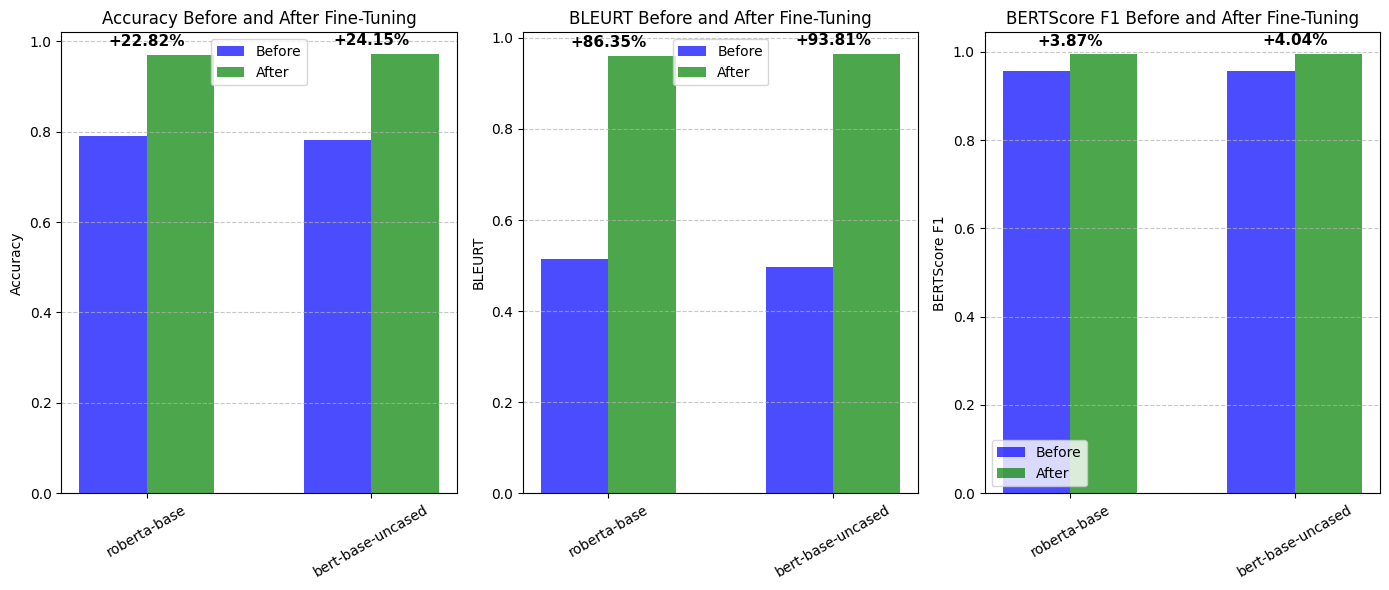


Final Comparison Dictionary (Percentage Improvement):
 {'roberta-base': {'Accuracy_Improvement (%)': 22.823330515638197, 'BLEURT_Improvement (%)': 86.3532233365538, 'BERTScore F1_Improvement (%)': 3.867056167510088}, 'bert-base-uncased': {'Accuracy_Improvement (%)': 24.146757679180876, 'BLEURT_Improvement (%)': 93.80686217357275, 'BERTScore F1_Improvement (%)': 4.044706780219904}}


In [ ]:
#Creating dataFrames for before and after fine-tuning
before_tuning_df=pd.DataFrame(model_performance).set_index("Model")
after_tuning_df=pd.DataFrame(tuned_model_performance_dict).T

#Merging both DataFrames for comparison
comparison_df=before_tuning_df.merge(after_tuning_df, left_index=True, right_index=True, suffixes=("_before", "_after"))

#Calculating the difference (After-Before) and percentage improvement
for metric in ["Accuracy", "BLEURT", "BERTScore F1"]:
    comparison_df[f"{metric}_Difference"]=comparison_df[f"{metric}_after"]-comparison_df[f"{metric}_before"]
    comparison_df[f"{metric}_Improvement (%)"]=(
        (comparison_df[f"{metric}_Difference"]/comparison_df[f"{metric}_before"])*100
    )

#Displaying the comparison results
print("\nComparison of Results Before and After Fine-Tuning:\n")
display(comparison_df)

#Plotting before, after, and percentage improvement
metrics=["Accuracy", "BLEURT", "BERTScore F1"]
x_labels=comparison_df.index
x=np.arange(len(x_labels))  #Label positions
width=0.3  #Bar width

fig,axs=plt.subplots(1,len(metrics),figsize=(14,6))
axs=axs.flatten()

#Ensuring axs is always iterable (even for a single plot)
if len(metrics)==1:
    axs=[axs]

for i, metric in enumerate(metrics):
    before_tuning_values=comparison_df[f"{metric}_before"]
    after_tuning_values=comparison_df[f"{metric}_after"]
    improvement_percentage=comparison_df[f"{metric}_Improvement (%)"]

    axs[i].bar(x-width/2, before_tuning_values, width, label="Before", color="blue", alpha=0.7)
    axs[i].bar(x+width/2, after_tuning_values, width, label="After", color="green", alpha=0.7)

    #Annotating percentage improvement above bars
    for j in range(len(x_labels)):
      sign="+" if improvement_percentage[j]>=0 else ""
      axs[i].text(x[j], max(before_tuning_values[j], after_tuning_values[j])+0.02,
                    f"{sign}{improvement_percentage[j]:.2f}%", ha="center", fontsize=11, fontweight="bold", color="black")

    axs[i].set_title(f"{metric} Before and After Fine-Tuning")
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(x_labels, rotation=30)
    axs[i].set_ylabel(metric)
    axs[i].legend()
    axs[i].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

#Displaying final comparison dictionary
comparison_dict=comparison_df[
    ["Accuracy_Improvement (%)", "BLEURT_Improvement (%)", "BERTScore F1_Improvement (%)"] #, "BLEU_Improvement (%)"
].to_dict(orient="index")

print("\nFinal Comparison Dictionary (Percentage Improvement):\n", comparison_dict)